# Global SuperStore Data



*   The Global Super Store data set is a customer centric dataset, which has the data of all the orders that have been place through different vendors and markets.​

*   The dataset set has around 50000 rows and 24 columns.​



## Importing the necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

# machine learning
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

## Loading the SuperStore data

In [2]:
# Laoding the data into a dataframe.
super_store_data = pd.read_excel("/content/Global_superstore_2016.xlsx")

In [3]:
super_store_data.shape

(51290, 24)

In [4]:
super_store_data.info() 
# info() gives us the number of non null values and the data type of each column.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  datetime64[ns]
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   Postal Code     9994 non-null   float64       
 9   City            51290 non-null  object        
 10  State           51290 non-null  object        
 11  Country         51290 non-null  object        
 12  Region          51290 non-null  object        
 13  Market          51290 non-null  object        
 14  Product ID      51290 non-null  object        
 15  Ca

Dropping the Customer Name column, as it contains personally identifiable information.

In [5]:
super_store_data = super_store_data.drop("Customer Name",axis=1)
# Looking at the top 5 rows of the dataframe.
super_store_data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Postal Code,City,State,Country,Region,Market,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.980,2,0.0,62.1544,40.77,High
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


## Exploratory Data Analysis

Verifying if the data contains null values:

In [6]:
super_store_data.isnull().sum()

Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Segment               0
Postal Code       41296
City                  0
State                 0
Country               0
Region                0
Market                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64

As postal code doesn't play a key role for CLV analysis, we are ignoring the missing postal codes.

Performing statistical analysis on the applicable features:

In [7]:
# looking at the min, max, mean, standard deviation and quartile values of the numerical values.
super_store_data[["Sales", "Quantity", "Discount", "Profit", "Shipping Cost"]].describe()

,Sales,Quantity,Discount,Profit,Shipping Cost
count,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,246.490581,3.476545,0.142908,28.610982,26.478567
std,487.565361,2.278766,0.212280,174.340972,57.251373
min,0.444000,1.000000,0.000000,-6599.978000,1.002000
25%,30.758625,2.000000,0.000000,0.000000,2.610000
50%,85.053000,3.000000,0.000000,9.240000,7.790000
75%,251.053200,5.000000,0.200000,36.810000,24.450000
max,22638.480000,14.000000,0.850000,8399.976000,933.570000


In [8]:
# First Transaction Date
super_store_data["Order Date"].min()

Timestamp('2012-01-01 00:00:00')

In [9]:
# Last Transaction Date
super_store_data["Order Date"].max()

Timestamp('2015-12-31 00:00:00')

In [10]:
# NUmber of Unique Customers
super_store_data["Customer ID"].nunique()

17415

In [11]:
# Total Revenue.
super_store_data["Sales"].sum()

12642501.90988

In [12]:
#Mean Sales value per transaction
super_store_data["Sales"].mean()

246.4905812025821

In [13]:
super_store_data["Sales"].median()

85.053

In [14]:
order_count = pd.DataFrame((super_store_data.groupby("Customer ID")["Order Date"].count()).sort_values(ascending=False))


In [15]:
order_count[order_count["Order Date"]>1].shape

(11350, 1)

In [16]:
#Average of mean sales per customer
super_store_data.groupby("Customer ID")["Sales"].mean().mean()

241.38291683146747

Analysing the Profit feature, as above noticed transactions with negative profit

In [17]:
super_store_data[super_store_data["Profit"]<0].transpose()

,1,3,16,30,40,65,73,76,83,85,91,93,98,109,111,117,123,124,126,137,148,150,167,169,170,172,174,182,188,193,197,199,203,208,209,231,232,245,254,259,...,51194,51195,51196,51199,51201,51205,51206,51207,51209,51210,51214,51216,51218,51219,51220,51223,51224,51228,51229,51230,51231,51232,51233,51235,51237,51238,51240,51242,51244,51245,51246,51252,51256,51257,51259,51260,51266,51275,51277,51279
Row ID,26341,13524,39519,220,21316,32637,21209,33130,40425,23013,34336,32639,15896,11743,17522,32638,24260,13646,39466,30267,22488,15376,20601,25915,21639,23229,20674,10745,29651,39745,39742,17907,28875,2641,39711,38383,37340,46219,21667,38382,...,11864,33366,19926,24448,45765,41392,38244,38245,41394,32495,49259,31885,48012,41430,29010,25164,36974,41771,32344,8277,1230,46812,42348,49802,22652,3569,48167,44081,41863,24004,31887,40220,29192,35397,36230,35398,27081,46231,46582,43818
Order ID,IN-2014-JR162107-41675,ES-2014-KM1637548-41667,CA-2012-AB10015140-40958,US-2012-RR1952536-41270,ID-2014-JB1600059-41873,CA-2015-AS10045140-42007,IN-2015-LA1678059-42242,CA-2015-AS10045140-42218,US-2015-AS10045140-42252,ID-2013-AM1070559-41535,CA-2015-AS10045140-42281,CA-2015-AS10045140-42007,IT-2013-PM1894045-41546,IT-2014-VM2168591-41711,ES-2013-DM1352548-41369,CA-2015-AS10045140-42007,ID-2014-JK153257-41984,IT-2015-RP1927045-42081,CA-2015-AB10060140-42315,ID-2013-AB1001527-41439,ID-2014-CR126257-41878,IT-2012-GM1468091-41215,ID-2014-AD1018059-41801,ID-2015-AA10480130-42080,ID-2014-RL196157-41641,ID-2013-SW2024559-41557,IN-2012-BW1111027-41076,IT-2012-TC2129545-41058,ID-2014-JS1603059-41760,CA-2015-AH10075140-42301,CA-2015-AH10075140-42301,ES-2012-NB1865548-41194,ID-2015-SC20380102-42165,US-2012-LH1675036-41129,CA-2014-AH10075140-41991,CA-2015-AH10075140-42273,CA-2015-AH10075140-42144,LH-2015-JC610575-42032,ID-2014-HJ1487527-41875,CA-2015-AH10075140-42273,...,ES-2015-GB1457591-42284,CA-2013-ZC21910140-41377,ES-2014-GM14695139-41835,IN-2014-JH1582097-41655,TU-2013-JB5925134-41579,NI-2015-KM637595-42045,CA-2013-ZC21910140-41389,CA-2013-ZC21910140-41389,TU-2014-LD7005134-41884,CA-2014-ZC21910140-41738,NI-2014-MP796595-41916,US-2014-ZC21910140-41719,ZA-2015-NG8430147-42332,TU-2014-ON8715134-41910,ID-2015-PC19000102-42348,ID-2012-RR1952559-40979,CA-2012-ZC21910140-41271,TU-2015-TB11520134-42351,CA-2014-ZC21910140-41707,US-2013-SV209355-41601,US-2012-MH1811555-41126,NI-2015-AS22595-42350,NI-2013-AA64595-41434,TU-2013-CR2730134-41597,IN-2015-EJ13720118-42320,US-2014-GK1462036-41989,NI-2015-JR570095-42356,TU-2014-LW6990134-41804,KZ-2012-LS723068-41261,IN-2012-MV1748597-41215,US-2014-ZC21910140-41719,CA-2015-ZC21910140-42167,ID-2015-JE1561097-42193,US-2015-ZC21910140-42175,CA-2013-ZC21910140-41545,US-2015-ZC21910140-42175,ID-2013-EK13795102-41496,ZA-2012-AS285147-40988,TU-2015-KF6285134-42337,NI-2012-PO886595-41159
Order Date,2014-02-05 00:00:00,2014-01-28 00:00:00,2012-02-19 00:00:00,2012-12-27 00:00:00,2014-08-22 00:00:00,2015-01-03 00:00:00,2015-08-26 00:00:00,2015-08-02 00:00:00,2015-09-05 00:00:00,2013-09-18 00:00:00,2015-10-04 00:00:00,2015-01-03 00:00:00,2013-09-29 00:00:00,2014-03-13 00:00:00,2013-04-05 00:00:00,2015-01-03 00:00:00,2014-12-11 00:00:00,2015-03-18 00:00:00,2015-11-07 00:00:00,2013-06-14 00:00:00,2014-08-27 00:00:00,2012-11-02 00:00:00,2014-06-11 00:00:00,2015-03-17 00:00:00,2014-01-02 00:00:00,2013-10-10 00:00:00,2012-06-16 00:00:00,2012-05-29 00:00:00,2014-05-01 00:00:00,2015-10-24 00:00:00,2015-10-24 00:00:00,2012-10-12 00:00:00,2015-06-10 00:00:00,2012-08-08 00:00:00,2014-12-18 00:00:00,2015-09-26 00:00:00,2015-05-20 00:00:00,2015-01-28 00:00:00,2014-08-24 00:00:00,2015-09-26 00:00:00,...,2015-10-07 00:00:00,2013-04-13 00:00:00,2014-07-15 00:00:00,2014-01-16 00:00:00,2013-11-01 00:00:00,2015-02-10 00:00:00,2013-04-25 00:00:00,2013-04-25 00:00:00,2014-09-02 00:00:00,2014-04-09 00:00:00,2014-10-04 00:00:00,2014-03-21 00:00:00,2015-11-24 00:00:00,2014-09-28 00:00:00,2015-12-10 00:00:00,2012-03-11 00:00:00,2012-12-28 00:00:00,2015-12-13 00:00:00,

Observed that there are 12544 transations with negative profit. As not every transaction is profitable, considering the negative profit transactions as correct data

In [18]:
print("Count of orders per customer:")
pd.DataFrame(super_store_data["Customer ID"].value_counts())

Count of orders per customer:


,Customer ID
SV-203651406,26
WB-218501404,24
AP-109151404,23
EM-1396082,21
CS-121757,20
...,...
FH-1436548,1
ME-18010124,1
SW-20350104,1
FM-421533,1


In [19]:
print("Total unique customers:")
super_store_data["Customer ID"].nunique()

Total unique customers:


17415

### How many orders are placed by most customers?

In [20]:
super_store_data["Customer ID"].value_counts()

SV-203651406    26
WB-218501404    24
AP-109151404    23
EM-1396082      21
CS-121757       20
                ..
FH-1436548       1
ME-18010124      1
SW-20350104      1
FM-421533        1
DL-1333026       1
Name: Customer ID, Length: 17415, dtype: int64

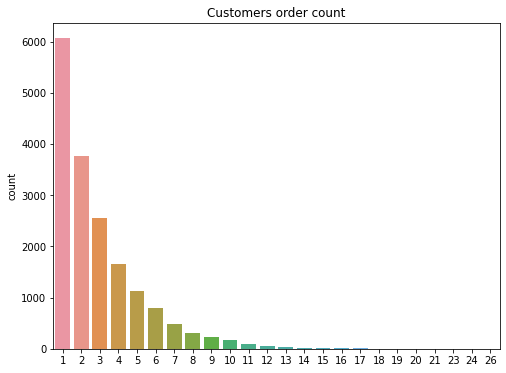

In [21]:
plt.figure(figsize=(8,6))
sns.countplot(x=super_store_data["Customer ID"].value_counts().values)
plt.title("Customers order count")
plt.show()

From the above visual, I conclude that majority of the customers placed 1- 2 orders during the period of study

### How has the order count been over the time period?

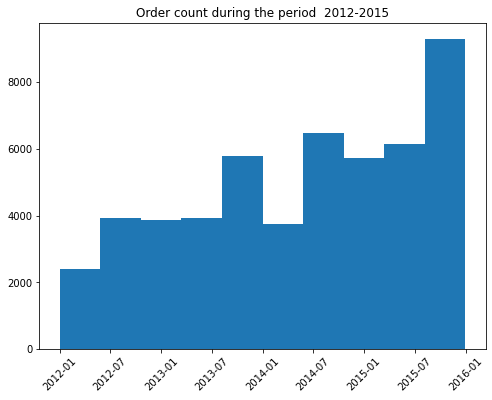

In [22]:
plt.figure(figsize=(8,6))
plt.hist(super_store_data["Order Date"])
plt.title("Order count during the period  2012-2015")
plt.xticks(rotation=45)
plt.show()

Noticed that the orders count increased as the time progressed

### What's the customer segment that's placing most orders?

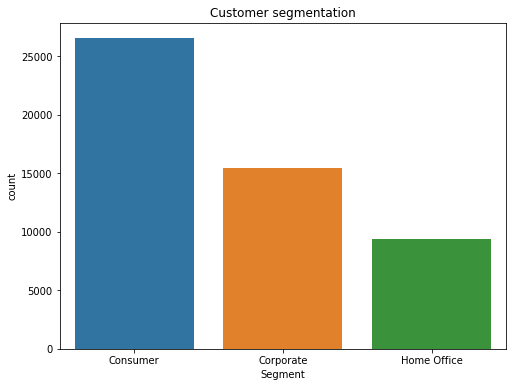

In [23]:
plt.figure(figsize=(8,6))
sns.countplot(data=super_store_data, x= "Segment")
plt.title("Customer segmentation")
plt.show()

Consumers segment is placing the most orders followed by corporate

In [24]:
super_store_data["City"].value_counts()

New York City    915
Los Angeles      747
Philadelphia     537
San Francisco    510
Santo Domingo    443
                ... 
Piacenza           1
Libourne           1
Cheyenne           1
Atlantic City      1
Tatuí              1
Name: City, Length: 3650, dtype: int64

In [25]:
print("Orders have been shipped to {} cities".format(super_store_data["City"].nunique()))

Orders have been shipped to 3650 cities


In [26]:
super_store_data["Country"].value_counts()

United States    9994
Australia        2837
France           2827
Mexico           2635
Germany          2063
                 ... 
The Gambia          1
Suriname            1
Malawi              1
Kuwait              1
Bhutan              1
Name: Country, Length: 165, dtype: int64

In [27]:
print("Orders have been shipped to {} countries".format(super_store_data["Country"].nunique()))

Orders have been shipped to 165 countries


### What's the customer base in each region?

In [28]:
super_store_data["Region"].value_counts()

Western Europe       5883
Central America      5616
Oceania              3487
Western US           3203
Southeastern Asia    3129
South America        2988
Eastern US           2848
Southern Asia        2655
Western Asia         2440
Eastern Asia         2374
Central US           2323
Northern Europe      2204
Southern Europe      2113
Caribbean            1690
Southern US          1620
Eastern Europe       1529
Western Africa       1460
North Africa         1278
Eastern Africa        728
Central Africa        643
Southern Africa       478
Canada                384
Central Asia          217
Name: Region, dtype: int64

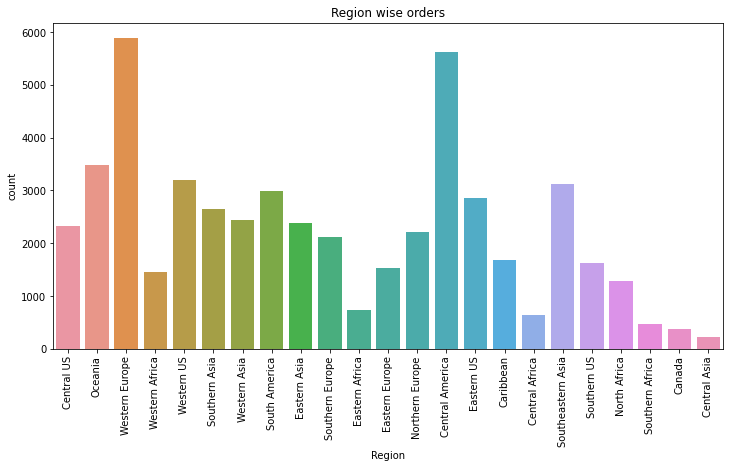

In [29]:
plt.figure(figsize=(12,6))
sns.countplot(data=super_store_data, x= "Region")
plt.title("Region wise orders")
plt.xticks(rotation=90)
plt.show()

### What's the orders share from each region?

In [30]:
super_store_data["Market"].value_counts()

Asia Pacific    14302
Europe          11729
USCA            10378
LATAM           10294
Africa           4587
Name: Market, dtype: int64

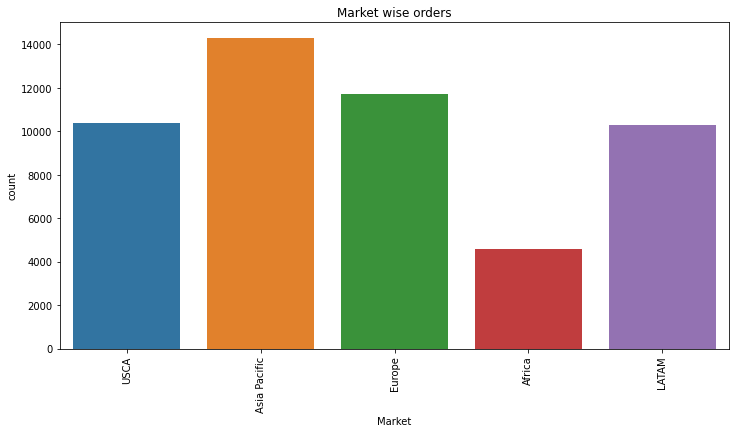

In [31]:
plt.figure(figsize=(12,6))
sns.countplot(data=super_store_data, x= "Market")
plt.title("Market wise orders")
plt.xticks(rotation=90)
plt.show()

### What category of products are most sold?

In [32]:
super_store_data["Category"].value_counts()

Office Supplies    31289
Technology         10141
Furniture           9860
Name: Category, dtype: int64

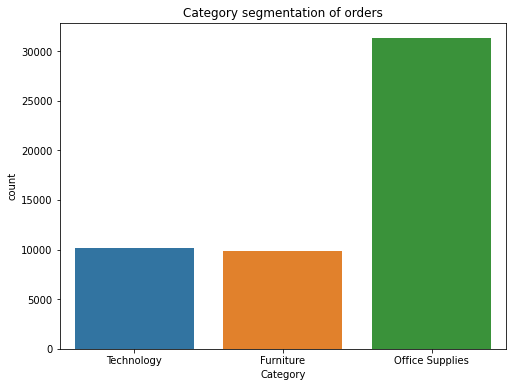

In [33]:
plt.figure(figsize=(8,6))
sns.countplot(data=super_store_data,x="Category")
plt.title("Category segmentation of orders")
plt.show()

From the above visual, it is clear that the Global superstore dataset consists of maily office supplies related orders during the period of study

In [34]:
super_store_data["Sub-Category"].value_counts()

Binders        6146
Storage        5049
Art            4864
Paper          3492
Chairs         3434
Phones         3357
Furnishings    3154
Accessories    3075
Labels         2601
Fasteners      2601
Bookcases      2411
Supplies       2407
Envelopes      2387
Copiers        2223
Appliances     1742
Machines       1486
Tables          861
Name: Sub-Category, dtype: int64

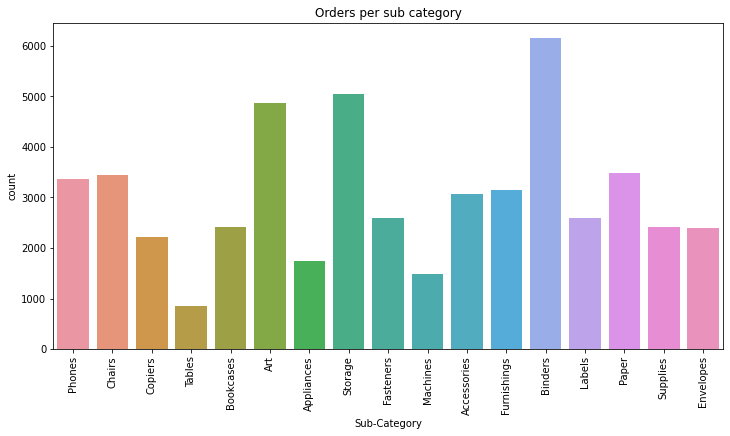

In [35]:
plt.figure(figsize=(12,6))
sns.countplot(data=super_store_data, x="Sub-Category")
plt.xticks(rotation=90)
plt.title("Orders per sub category")
plt.show()

### Customers generating the most sales?

In [36]:
super_store_data.groupby("Customer ID")["Sales"].sum().sort_values(ascending=False)

Customer ID
SM-203201408    23669.196
TC-209801402    18437.138
RB-193601404    14345.276
TA-213851406    13723.498
AB-101051402    12181.594
                  ...    
CC-123701402        1.248
KN-164501408        1.167
TS-213401402        1.112
JO-152801406        0.852
RS-197651402        0.556
Name: Sales, Length: 17415, dtype: float64

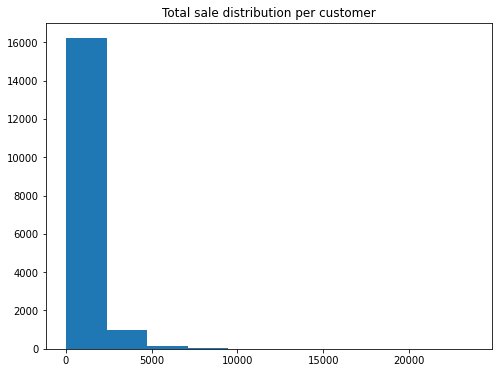

In [37]:
plt.figure(figsize=(8,6))
plt.hist(super_store_data.groupby("Customer ID")["Sales"].sum().values)
plt.title("Total sale distribution per customer")
plt.show()

### Customers placing the most orders?

In [38]:
super_store_data.groupby("Customer ID")["Order ID"].count().sort_values(ascending=False)

Customer ID
SV-203651406    26
WB-218501404    24
AP-109151404    23
EM-1396082      21
CS-121757       20
                ..
DB-13660124      1
DB-13660139      1
KE-1642092       1
NL-18310124      1
ON-18715120      1
Name: Order ID, Length: 17415, dtype: int64

## Cohort Analysis

In [39]:
# Customers first transaction. Considering the first transaction of the customers as a subset to perfrom our analysis.
GD_FIRST_TRANSACTION = super_store_data.sort_values(["Customer ID", "Order Date"]) \
                               .groupby("Customer ID").first()
GD_FIRST_TRANSACTION.shape

(17415, 22)

In [40]:
# first new customer.
GD_FIRST_TRANSACTION["Order Date"].min()

Timestamp('2012-01-01 00:00:00')

In [41]:
# last new customer
GD_FIRST_TRANSACTION["Order Date"].max()

Timestamp('2015-12-31 00:00:00')

In [42]:
# GETTING THE UNIQUE CUSTOMERS ID's
IDs = super_store_data['Customer ID'].unique()
IDs_SAMPLE = IDs[0:10]

In [43]:
# Creating a subset of the dataset with ten unique customer IDs
GD_SUBSET = super_store_data[super_store_data['Customer ID'].isin(IDs_SAMPLE)].groupby(['Customer ID', 'Order Date']).sum().reset_index()
GD_SUBSET.head()

,Customer ID,Order Date,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost
0,AB-100151402,2012-02-19,39519,76017.0,12.624,2,0.2,-2.5248,1.97
1,AB-100151402,2014-11-11,80197,146240.0,563.940,4,0.0,116.8680,66.04
2,AB-100151404,2012-03-06,108777,294309.0,309.592,7,0.2,15.0033,16.70
3,AJ-107801,2013-04-19,28879,0.0,4626.150,5,0.0,647.5500,835.57
4,CR-127307,2014-05-01,63942,0.0,292.167,12,0.3,58.5870,30.69


In [44]:
pip install plydata

     |████████████████████████████████| 299 kB 7.6 MB/s 


In [45]:
import plotnine as pn
import plydata.cat_tools as cat

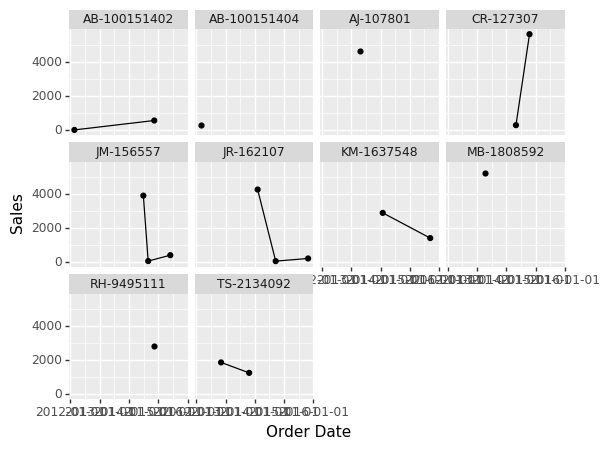

<ggplot: (8749886059853)>

In [46]:
# Frequency plot of the ten unique customers, with the price and date of each transaction.
pn.ggplot(pn.aes('Order Date', 'Sales', group = 'Customer ID'), data = GD_SUBSET) + pn.geom_line() +pn.geom_point() +pn.facet_wrap('Customer ID') +pn.scale_x_date(date_breaks = '1 year', date_lables = '%Y')

## Recency-Frequency-Monetary (RFM) analysis:

For Recency, calculating the number of days between present date and date of last purchase for each customer.

For Frequency, calculating the number of orders for each customer.

For Monetary, calculating the sum of purchase price for each customer.

In [47]:
transaction_data = super_store_data[['Customer ID','Order ID','Order Date','Sales', 'Quantity','Discount']].copy()
transaction_data

,Customer ID,Order ID,Order Date,Sales,Quantity,Discount
0,AB-100151402,CA-2014-AB10015140-41954,2014-11-11,221.980,2,0.0
1,JR-162107,IN-2014-JR162107-41675,2014-02-05,3709.395,9,0.1
2,CR-127307,IN-2014-CR127307-41929,2014-10-17,5175.171,9,0.1
3,KM-1637548,ES-2014-KM1637548-41667,2014-01-28,2892.510,5,0.1
4,RH-9495111,SG-2014-RH9495111-41948,2014-11-05,2832.960,8,0.0
...,...,...,...,...,...,...
51285,KE-1642066,IN-2015-KE1642066-42174,2015-06-19,65.100,5,0.0
51286,ZD-219251408,US-2014-ZD21925140-41765,2014-05-06,16.720,5,0.2
51287,ZD-219251404,CA-2012-ZD21925140-41147,2012-08-26,8.560,2,0.0
51288,RB-1979518,MX-2013-RB1979518-41322,2013-02-17,13.440,2,0.0


In [48]:
max_date_considered = transaction_data['Order Date'].max().date()
print("Date considered for calculating the recency: ", max_date_considered.strftime("%m-%d-%Y"))

Date considered for calculating the recency:  12-31-2015


In [49]:
# Count of days since their last purchase until current date
rfm = pd.DataFrame((max_date_considered - transaction_data.groupby("Customer ID")["Order Date"].max().apply(lambda x: x.date())).dt.days)
rfm

,Order Date
Customer ID,
AA-10315102,358
AA-10315120,959
AA-10315139,149
AA-103151402,184
AA-103151404,818
...,...
ZD-2192548,750
ZD-2192564,1409
ZD-219257,1198


In [50]:
rfm.columns = ["Recency"]
rfm.head()

,Recency
Customer ID,
AA-10315102,358
AA-10315120,959
AA-10315139,149
AA-103151402,184
AA-103151404,818


In [51]:
# Count of days between their last purchase and first purchase
transaction_data.groupby("Customer ID")["Order Date"].max().apply(lambda x: x.date()) - transaction_data.groupby("Customer ID")["Order Date"].min().apply(lambda x: x.date())

Customer ID
AA-10315102    918 days
AA-10315120      0 days
AA-10315139    319 days
AA-103151402   483 days
AA-103151404   553 days
                 ...   
ZD-2192548     385 days
ZD-2192564       0 days
ZD-219257        0 days
ZD-2192582     569 days
ZD-2192596       0 days
Name: Order Date, Length: 17415, dtype: timedelta64[ns]

In [52]:
# Orders per customer
frequency_orders = transaction_data.groupby("Customer ID")["Order ID"].count()
frequency_orders

Customer ID
AA-10315102      6
AA-10315120      1
AA-10315139     13
AA-103151402     6
AA-103151404     3
                ..
ZD-2192548       4
ZD-2192564       4
ZD-219257        1
ZD-2192582       2
ZD-2192596       2
Name: Order ID, Length: 17415, dtype: int64

In [53]:
rfm = rfm.merge(frequency_orders.reset_index(), left_on = "Customer ID", right_on= "Customer ID")
rfm.head()

,Customer ID,Recency,Order ID
0,AA-10315102,358,6
1,AA-10315120,959,1
2,AA-10315139,149,13
3,AA-103151402,184,6
4,AA-103151404,818,3


In [54]:
rfm.columns = ['Customer ID', 'Recency', 'Frequency']
rfm.head()

,Customer ID,Recency,Frequency
0,AA-10315102,358,6
1,AA-10315120,959,1
2,AA-10315139,149,13
3,AA-103151402,184,6
4,AA-103151404,818,3


In [55]:
# Sales per customer
sales_per_customer = transaction_data.groupby("Customer ID")["Sales"].sum()
sales_per_customer.reset_index()

,Customer ID,Sales
0,AA-10315102,544.6560
1,AA-10315120,2713.4100
2,AA-10315139,2955.7980
3,AA-103151402,4780.5520
4,AA-103151404,753.5080
...,...,...
17410,ZD-2192548,1302.1680
17411,ZD-2192564,1225.3920
17412,ZD-219257,59.9400
17413,ZD-2192582,678.1014


In [56]:
rfm = rfm.merge(sales_per_customer.reset_index(),left_on = "Customer ID", right_on="Customer ID")
rfm.head()

,Customer ID,Recency,Frequency,Sales
0,AA-10315102,358,6,544.656
1,AA-10315120,959,1,2713.410
2,AA-10315139,149,13,2955.798
3,AA-103151402,184,6,4780.552
4,AA-103151404,818,3,753.508


In [57]:
# Renaming the column names

rfm = rfm.set_index("Customer ID") #Setting customer ID as the index for rfm dataframe
rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
AA-10315102,358,6,544.656
AA-10315120,959,1,2713.410
AA-10315139,149,13,2955.798
AA-103151402,184,6,4780.552
AA-103151404,818,3,753.508


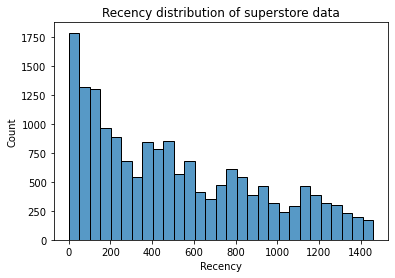

In [58]:
sns.histplot(rfm["Recency"])
plt.title("Recency distribution of superstore data")
plt.show()

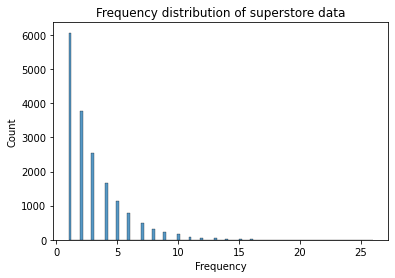

In [59]:
sns.histplot(rfm["Frequency"])
plt.title("Frequency distribution of superstore data")
plt.show()

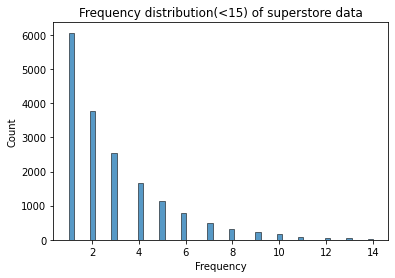

In [60]:
sns.histplot(rfm[rfm["Frequency"]<15]["Frequency"])
plt.title("Frequency distribution(<15) of superstore data")
plt.show()

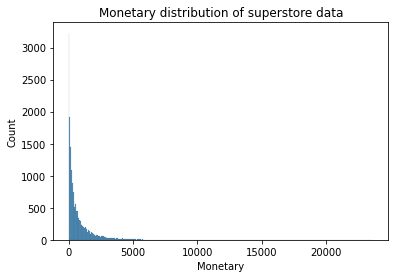

In [61]:
sns.histplot(rfm["Monetary"])
plt.title("Monetary distribution of superstore data")
plt.show()

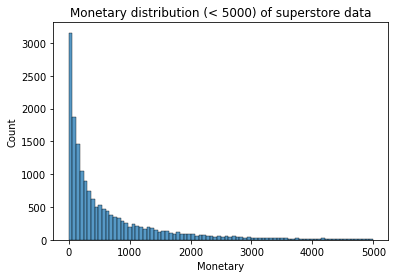

In [62]:
sns.histplot(rfm[rfm["Monetary"]<5000]["Monetary"])
plt.title("Monetary distribution (< 5000) of superstore data")
plt.show()

### Computing Quantile of RFM values
Customers with the lowest recency, highest frequency and monetary amounts considered as top customers.

In [63]:
rfm["Recency_quatile"] = pd.qcut(rfm["Recency"].rank(method="first"),4,['1','2','3','4']) 
# Using rank method to handle bins with duplicate edges
rfm["Frequency_quatile"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, ['4','3','2','1'])
rfm["Monetary_quantile"] = pd.qcut(rfm["Monetary"].rank(method="first"), 4, ['4','3','2','1'])
rfm.head()

,Recency,Frequency,Monetary,Recency_quatile,Frequency_quatile,Monetary_quantile
Customer ID,,,,,,
AA-10315102,358,6,544.656,2,1,2
AA-10315120,959,1,2713.410,4,4,1
AA-10315139,149,13,2955.798,2,1,1
AA-103151402,184,6,4780.552,2,1,1
AA-103151404,818,3,753.508,4,2,2


RFM Result Calculation:

Combining all three quartiles(r_quartile,f_quartile,m_quartile) to a single column, to segment the customers

In [64]:
rfm["RFM score"] = rfm[['Recency_quatile', 'Frequency_quatile', 'Monetary_quantile']].\
                    apply(lambda x: str(x[0])+str(x[1])+str(x[2]),axis=1)

In [65]:
rfm.head()

,Recency,Frequency,Monetary,Recency_quatile,Frequency_quatile,Monetary_quantile,RFM score
Customer ID,,,,,,,
AA-10315102,358,6,544.656,2,1,2,212
AA-10315120,959,1,2713.410,4,4,1,441
AA-10315139,149,13,2955.798,2,1,1,211
AA-103151402,184,6,4780.552,2,1,1,211
AA-103151404,818,3,753.508,4,2,2,422


In [66]:
# Identifing the top customers

rfm[rfm["RFM score"] == '111'].sort_values("Monetary",ascending=False)

,Recency,Frequency,Monetary,Recency_quatile,Frequency_quatile,Monetary_quantile,RFM score
Customer ID,,,,,,,
SM-203201408,79,8,23669.196,1,1,1,111
TA-213851406,69,5,13723.498,1,1,1,111
DP-131057,98,15,11864.139,1,1,1,111
FH-1436582,42,13,10880.180,1,1,1,111
VG-2180558,96,7,10058.040,1,1,1,111
...,...,...,...,...,...,...,...
TH-211151406,58,6,915.584,1,1,1,111
KA-165251406,36,6,914.578,1,1,1,111
GM-1468054,127,5,914.052,1,1,1,111


The top customer based on RFM analysis is 'SM-203201408'

### Using unsupervised learning - clustering based on each of RFM values


In [67]:
rfm_clustering = rfm[['Recency','Frequency', 'Monetary']].copy()
rfm_clustering.head()

,Recency,Frequency,Monetary
Customer ID,,,
AA-10315102,358,6,544.656
AA-10315120,959,1,2713.410
AA-10315139,149,13,2955.798
AA-103151402,184,6,4780.552
AA-103151404,818,3,753.508


In [68]:
rfm_clustering = rfm_clustering.reset_index()
rfm_clustering

,Customer ID,Recency,Frequency,Monetary
0,AA-10315102,358,6,544.6560
1,AA-10315120,959,1,2713.4100
2,AA-10315139,149,13,2955.7980
3,AA-103151402,184,6,4780.5520
4,AA-103151404,818,3,753.5080
...,...,...,...,...
17410,ZD-2192548,750,4,1302.1680
17411,ZD-2192564,1409,4,1225.3920
17412,ZD-219257,1198,1,59.9400
17413,ZD-2192582,196,2,678.1014


In order to perform k means clustering, scaling the data to avoid influence of scale during cluster identification

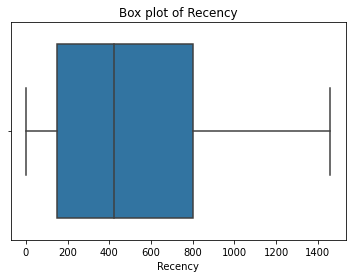

In [69]:
sns.boxplot(x = rfm_clustering["Recency"])
plt.title("Box plot of Recency")
plt.show()

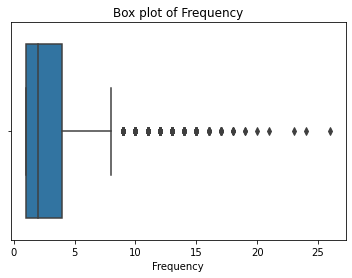

In [70]:
sns.boxplot(x = rfm_clustering["Frequency"])
plt.title("Box plot of Frequency")
plt.show()

In [71]:
rfm_clustering[rfm_clustering["Frequency"]>7].shape

(971, 4)

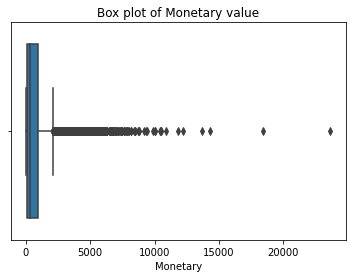

In [72]:
sns.boxplot(x = rfm_clustering["Monetary"])
plt.title("Box plot of Monetary value")
plt.show()

In [73]:
rfm_clustering[rfm_clustering["Monetary"]>2500].shape

(1088, 4)

As the box plot indicates, outliers in Frequency and Monetary values, of all the available scaling techniques, using the RobustScalar as the scaling happens based on percentiles and is not influenced by the few marginal outleirs in the data.

In [74]:
from sklearn.preprocessing import RobustScaler

In [75]:
rscaler = RobustScaler()

In [76]:
rfm_clustering["Recency_norm"] = rscaler.fit_transform(rfm_clustering[["Recency"]])

In [77]:
rfm_clustering["Frequency_norm"] = rscaler.fit_transform(rfm_clustering[["Frequency"]])
rfm_clustering["Monetary_norm"] = rscaler.fit_transform(rfm_clustering[["Monetary"]])

In [78]:
rfm_clustering.head()

,Customer ID,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm
0,AA-10315102,358,6,544.656,-0.096183,1.333333,0.267231
1,AA-10315120,959,1,2713.410,0.821374,-0.333333,2.929883
2,AA-10315139,149,13,2955.798,-0.415267,3.666667,3.227471
3,AA-103151402,184,6,4780.552,-0.361832,1.333333,5.467782
4,AA-103151404,818,3,753.508,0.606107,0.333333,0.523646


In [79]:
rfm_clustering[['Recency_norm', 'Frequency_norm', 'Monetary_norm']].describe()

,Recency_norm,Frequency_norm,Monetary_norm
count,17415.000000,17415.000000,17415.000000
mean,0.131432,0.315054,0.489817
std,0.611632,0.799824,1.307231
min,-0.642748,-0.333333,-0.400779
25%,-0.416794,-0.333333,-0.280720
50%,0.000000,0.000000,0.000000
75%,0.583206,0.666667,0.719280
max,1.586260,8.000000,28.658004


In [80]:
from sklearn.cluster import KMeans

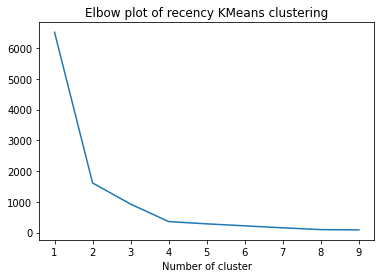

In [81]:
sse={}
recency = rfm_clustering[['Recency_norm']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Elbow plot of recency KMeans clustering")
plt.xlabel("Number of cluster")
plt.show()

In [82]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(recency[['Recency_norm']])
rfm_clustering['RecencyCluster'] = kmeans.predict(rfm_clustering[['Recency_norm']])

In [83]:
rfm_clustering

,Customer ID,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,RecencyCluster
0,AA-10315102,358,6,544.6560,-0.096183,1.333333,0.267231,2
1,AA-10315120,959,1,2713.4100,0.821374,-0.333333,2.929883,1
2,AA-10315139,149,13,2955.7980,-0.415267,3.666667,3.227471,0
3,AA-103151402,184,6,4780.5520,-0.361832,1.333333,5.467782,0
4,AA-103151404,818,3,753.5080,0.606107,0.333333,0.523646,1
...,...,...,...,...,...,...,...,...
17410,ZD-2192548,750,4,1302.1680,0.502290,0.666667,1.197254,1
17411,ZD-2192564,1409,4,1225.3920,1.508397,0.666667,1.102993,3
17412,ZD-219257,1198,1,59.9400,1.186260,-0.333333,-0.327871,3
17413,ZD-2192582,196,2,678.1014,-0.343511,0.000000,0.431066,0


In [84]:
def order_cluster(cluster_field, target_field,df,ascending):
    """
    function to assign the label values based on a particular sorting order defined as a parameter
    
    cluster_field: Field/column name storing the cluster
    target_field: Field storing the respective rfm actual values
    df: dataframe
    ascending: True/False
    
    """
    
    df_new = df.groupby(cluster_field)[target_field].mean().reset_index()
    df_new = df_new.sort_values(by=target_field,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field,'index']], on=cluster_field)
    df_final = df_final.drop([cluster_field],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field})
    return df_final

In [85]:
rfm_clustering = order_cluster("RecencyCluster", "Recency", rfm_clustering,False)
rfm_clustering

,Customer ID,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,RecencyCluster
0,AA-10315102,358,6,544.656,-0.096183,1.333333,0.267231,2
1,AA-1031548,511,1,68.148,0.137405,-0.333333,-0.317794,2
2,AA-10375101,551,4,243.486,0.198473,0.666667,-0.102526,2
3,AA-103751404,538,4,72.808,0.178626,0.666667,-0.312073,2
4,AA-103751408,411,4,598.480,-0.015267,0.666667,0.333312,2
...,...,...,...,...,...,...,...,...
17410,YS-2188044,1167,3,657.360,1.138931,0.333333,0.405601,0
17411,ZD-11925134,1028,1,13.560,0.926718,-0.333333,-0.384813,0
17412,ZD-1192583,1120,1,241.800,1.067176,-0.333333,-0.104596,0
17413,ZD-2192564,1409,4,1225.392,1.508397,0.666667,1.102993,0


In [86]:
rfm_clustering["RecencyCluster"].value_counts()

3    6698
2    4799
1    3381
0    2537
Name: RecencyCluster, dtype: int64

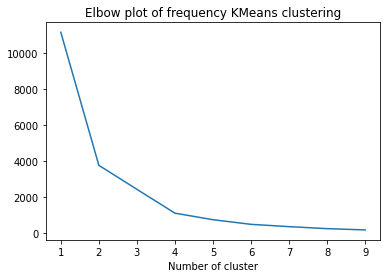

In [87]:
sse={}
frequency = rfm_clustering[['Frequency_norm']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(frequency)
    frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Elbow plot of frequency KMeans clustering")
plt.xlabel("Number of cluster")
plt.show()

In [88]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm_clustering[['Frequency_norm']])
rfm_clustering['FrequencyCluster'] = kmeans.predict(rfm_clustering[['Frequency_norm']])

In [89]:
rfm_clustering = order_cluster("FrequencyCluster", "Frequency", rfm_clustering,True)
rfm_clustering

,Customer ID,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,RecencyCluster,FrequencyCluster
0,AA-10315102,358,6,544.6560,-0.096183,1.333333,0.267231,2,2
1,AA-1037564,366,6,469.6020,-0.083969,1.333333,0.175085,2,2
2,AA-1064564,355,5,439.5000,-0.100763,1.000000,0.138127,2,2
3,AB-1001545,322,5,2822.7270,-0.151145,1.000000,3.064095,2,2
4,AB-1001548,295,6,733.1760,-0.192366,1.333333,0.498683,2,2
...,...,...,...,...,...,...,...,...,...
17410,MY-1829527,1055,12,4634.3100,0.967939,3.333333,5.288236,0,3
17411,RH-9555110,1245,9,4055.6100,1.258015,2.333333,4.577747,0,3
17412,SB-2017027,1161,12,6577.6500,1.129771,3.333333,7.674140,0,3
17413,SC-200201402,1147,16,2785.3796,1.108397,4.666667,3.018242,0,3


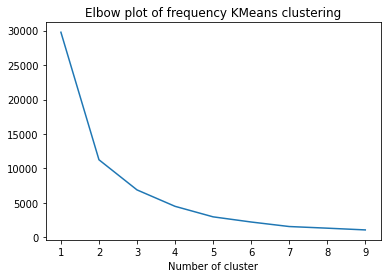

In [90]:
sse={}
monetary = rfm_clustering[['Monetary_norm']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(monetary)
    monetary["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Elbow plot of frequency KMeans clustering")
plt.xlabel("Number of cluster")
plt.show()

In [91]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm_clustering[['Monetary_norm']])
rfm_clustering['MonetaryCluster'] = kmeans.predict(rfm_clustering[['Monetary']])

In [92]:
rfm_clustering = order_cluster("MonetaryCluster", "Monetary", rfm_clustering,True)
rfm_clustering

,Customer ID,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,RecencyCluster,FrequencyCluster,MonetaryCluster
0,AA-10315102,358,6,544.656,-0.096183,1.333333,0.267231,2,2,2
1,AA-1037564,366,6,469.602,-0.083969,1.333333,0.175085,2,2,2
2,AA-1064564,355,5,439.500,-0.100763,1.000000,0.138127,2,2,2
3,AB-1001545,322,5,2822.727,-0.151145,1.000000,3.064095,2,2,2
4,AB-1001548,295,6,733.176,-0.192366,1.333333,0.498683,2,2,2
...,...,...,...,...,...,...,...,...,...,...
17410,NG-184301406,1133,1,2.624,1.087023,-0.333333,-0.398240,0,0,1
17411,PF-9165134,1295,1,2.652,1.334351,-0.333333,-0.398206,0,0,1
17412,TS-1137095,1182,1,2.286,1.161832,-0.333333,-0.398655,0,0,1
17413,TS-213401402,1026,1,1.112,0.923664,-0.333333,-0.400096,0,0,1


In [93]:
rfm_clustering['OverallScore'] = rfm_clustering['RecencyCluster'] + rfm_clustering['FrequencyCluster'] + rfm_clustering['MonetaryCluster']

In [94]:
rfm_clustering["OverallScore"].value_counts()

5    4773
4    3594
3    2743
6    2495
2    1801
7    1563
8     436
1      10
Name: OverallScore, dtype: int64

In [95]:
rfm_clustering.groupby(["OverallScore"])[["Recency","Frequency", "Monetary"]].mean()

,Recency,Frequency,Monetary
OverallScore,,,
1,1191.200000,1.000000,2.295100
2,1218.500833,1.332593,311.799810
3,899.242800,1.743711,416.505099
4,566.322204,2.023372,482.347390
5,269.210769,2.322858,563.174709
6,228.860120,4.305010,1082.385648
7,142.925144,6.543826,1703.270438
8,99.032110,10.938073,2647.020004


In [96]:
rfm_clustering.groupby('OverallScore')['Customer ID'].count()

OverallScore
1      10
2    1801
3    2743
4    3594
5    4773
6    2495
7    1563
8     436
Name: Customer ID, dtype: int64

In [97]:
rfm_clustering

,Customer ID,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,RecencyCluster,FrequencyCluster,MonetaryCluster,OverallScore
0,AA-10315102,358,6,544.656,-0.096183,1.333333,0.267231,2,2,2,6
1,AA-1037564,366,6,469.602,-0.083969,1.333333,0.175085,2,2,2,6
2,AA-1064564,355,5,439.500,-0.100763,1.000000,0.138127,2,2,2,6
3,AB-1001545,322,5,2822.727,-0.151145,1.000000,3.064095,2,2,2,6
4,AB-1001548,295,6,733.176,-0.192366,1.333333,0.498683,2,2,2,6
...,...,...,...,...,...,...,...,...,...,...,...
17410,NG-184301406,1133,1,2.624,1.087023,-0.333333,-0.398240,0,0,1,1
17411,PF-9165134,1295,1,2.652,1.334351,-0.333333,-0.398206,0,0,1,1
17412,TS-1137095,1182,1,2.286,1.161832,-0.333333,-0.398655,0,0,1,1
17413,TS-213401402,1026,1,1.112,0.923664,-0.333333,-0.400096,0,0,1,1


In [98]:
rfm_clustering['Segment'] = 'Lost Customer'
rfm_clustering.loc[rfm_clustering['OverallScore']>2,'Segment'] = 'Low-Value' 
rfm_clustering.loc[rfm_clustering['OverallScore']>3,'Segment'] = 'Mid-Value'
rfm_clustering.loc[rfm_clustering['OverallScore']>5,'Segment'] = 'High-Value'
rfm_clustering.loc[rfm_clustering['OverallScore']>7,'Segment'] = 'Top Customer'

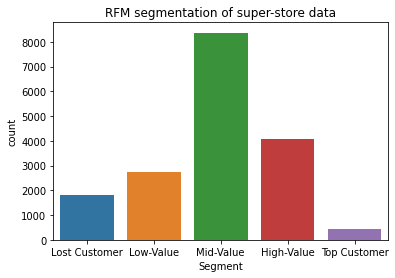

In [99]:
sns.countplot(x=rfm_clustering["Segment"],order= ['Lost Customer','Low-Value' ,'Mid-Value','High-Value','Top Customer'])
plt.title("RFM segmentation of super-store data")
plt.show()

Here, Top customers are the ones with low recency, high frequency and high monetary values; whereas lost customers are the ones who have high recency, low frequency and low monetary value

In [100]:
rfm_clustering['Segment'].value_counts()

Mid-Value        8367
High-Value       4058
Low-Value        2743
Lost Customer    1811
Top Customer      436
Name: Segment, dtype: int64

In [101]:
rfm_clustering[rfm_clustering["Segment"]=='Top Customer']

,Customer ID,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,RecencyCluster,FrequencyCluster,MonetaryCluster,OverallScore,Segment
16907,AA-10315139,149,13,2955.7980,-0.415267,3.666667,3.227471,3,3,2,8,Top Customer
16908,AA-1064559,28,12,1873.2195,-0.600000,3.333333,1.898353,3,3,2,8,Top Customer
16909,AA-64595,60,11,555.0840,-0.551145,3.000000,0.280034,3,3,2,8,Top Customer
16910,AB-101051402,149,11,12181.5940,-0.415267,3.000000,14.554290,3,3,2,8,Top Customer
16911,AB-101057,216,10,2960.5770,-0.312977,2.666667,3.233338,3,3,2,8,Top Customer
...,...,...,...,...,...,...,...,...,...,...,...,...
17338,XP-218651404,82,12,660.1900,-0.517557,3.333333,0.409076,3,3,2,8,Top Customer
17339,YC-2189545,43,18,4160.7435,-0.577099,5.333333,4.706823,3,3,2,8,Top Customer
17340,YS-2188031,125,9,1842.4000,-0.451908,2.333333,1.860515,3,3,2,8,Top Customer
17341,ZC-219101402,194,11,3869.8060,-0.346565,3.000000,4.349629,3,3,2,8,Top Customer


In [102]:
rfm_clustering[["Customer ID", 'Monetary', 'Frequency','Recency', 'RecencyCluster', 'FrequencyCluster',
       'MonetaryCluster', 'OverallScore', 'Segment']].to_csv("RFM_segmentation.csv")

In [103]:
super_store_data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Postal Code,City,State,Country,Region,Market,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.980,2,0.0,62.1544,40.77,High
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


In [104]:
super_store_data.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Segment', 'Postal Code', 'City', 'State', 'Country',
       'Region', 'Market', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Shipping Cost', 'Order Priority'],
      dtype='object')

## Machine Learning Modelling
### Time Split

Performing time split, to split the data into train and test wherein test data, indicates if the customer purchased in the following 90 days and if yes, what's the sale amount

In [105]:
n_days = 90   
max_date = super_store_data['Order Date'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit = 'd')

In [106]:
temporal_in_df = super_store_data[super_store_data['Order Date']<= cutoff][['Order Date', 
       'Customer ID', 'Sales']]
temporal_out_df = super_store_data[super_store_data['Order Date']> cutoff][['Order Date', 
       'Customer ID', 'Sales']]

## Feature Engineering

In [107]:
#make targets from out data
targets_df = temporal_out_df.groupby('Customer ID').sum().rename({'Sales':'spend_90_total'}, axis = 1).assign(spend_90_flag = 1)
targets_df

,spend_90_total,spend_90_flag
Customer ID,,
AA-1031545,368.2710,1
AA-1031558,45.9900,1
AA-103751406,149.8720,1
AA-103757,444.4200,1
AA-1037582,79.9000,1
...,...,...
ZC-219107,2254.2840,1
ZC-2191082,102.7400,1
ZD-1192538,140.5800,1


In [108]:
targets_df["spend_90_total"].sort_values()

Customer ID
PC-187451404        1.188
CC-123701402        1.248
DK-133751402        1.392
ND-846095           1.935
AH-12068            2.052
                  ...    
DL-133158        7383.810
GT-146351408     8167.420
BF-1100558       9286.830
HL-150401406    10522.550
TA-213851406    13716.458
Name: spend_90_total, Length: 2784, dtype: float64

In [109]:
# make recency (date) features from in data
max_date = temporal_in_df['Order Date'].max()

In [110]:
recency_features_df = temporal_in_df[['Customer ID', 'Order Date']].groupby('Customer ID').apply(lambda x: (x['Order Date'].max() - max_date)/ pd.to_timedelta(1, 'day')).to_frame().set_axis(['recency'], axis = 1)

In [111]:
recency_features_df.head()

,recency
Customer ID,
AA-10315102,-268.0
AA-10315120,-869.0
AA-10315139,-59.0
AA-103151402,-94.0
AA-103151404,-728.0


In [112]:
# make frequency (count features from in data)
frequency_features_df = temporal_in_df[['Customer ID', 'Order Date']].groupby('Customer ID').count().set_axis(['frequency'], axis = 1)
frequency_features_df.head()

,frequency
Customer ID,
AA-10315102,6
AA-10315120,1
AA-10315139,13
AA-103151402,6
AA-103151404,3


In [113]:
# make price (monitery features from in data)
price_features_df = temporal_in_df.groupby('Customer ID').aggregate({'Sales':['sum', 'mean']}).set_axis(['price_sum', 'price_mean'], axis = 1)
price_features_df.head()

,price_sum,price_mean
Customer ID,,
AA-10315102,544.656,90.776000
AA-10315120,2713.410,2713.410000
AA-10315139,2955.798,227.369077
AA-103151402,4780.552,796.758667
AA-103151404,753.508,251.169333


In [114]:
# combine features
features_df = pd.concat([recency_features_df, frequency_features_df, price_features_df], axis = 1).merge(targets_df, left_index = True, right_index = True, how = 'left').fillna(0)
features_df

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
Customer ID,,,,,,
AA-10315102,-268.0,6,544.6560,90.776000,0.0,0.0
AA-10315120,-869.0,1,2713.4100,2713.410000,0.0,0.0
AA-10315139,-59.0,13,2955.7980,227.369077,0.0,0.0
AA-103151402,-94.0,6,4780.5520,796.758667,0.0,0.0
AA-103151404,-728.0,3,753.5080,251.169333,0.0,0.0
...,...,...,...,...,...,...
ZD-2192548,-660.0,4,1302.1680,325.542000,0.0,0.0
ZD-2192564,-1319.0,4,1225.3920,306.348000,0.0,0.0
ZD-219257,-1108.0,1,59.9400,59.940000,0.0,0.0


## Perfroming various predictive modelling techniques:

### Predictve modelling for next 90 days behaviour:

#### How much will the customers spend in the next 90 days?

In [115]:
# machine laerning

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

In [116]:
features_df.loc['AA-10315139',:]

recency            -59.000000
frequency           13.000000
price_sum         2955.798000
price_mean         227.369077
spend_90_total       0.000000
spend_90_flag        0.000000
Name: AA-10315139, dtype: float64

In [117]:
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]

In [118]:
# next 90 days spend prediction
y_spend = features_df['spend_90_total']

In [119]:
X.shape

(16002, 4)

In [120]:
y_spend.shape

(16002,)

##### XGBoost

In [121]:
xgb_reg_spec = XGBRegressor(objective='reg:squarederror', random_state=123)

In [122]:
# Creating a GridSearchCV to tune the hyperparameters
xgb_reg_model =GridSearchCV(estimator=xgb_reg_spec, param_grid = dict(learning_rate = [0.01, 0.1, 0.3, 0.5]), scoring='neg_mean_absolute_error', refit= True, cv = 5) 

In [123]:
# Fitting the Model
xgb_reg_model.fit(X, y_spend)

GridSearchCV(cv=5,
             estimator=XGBRegressor(objective='reg:squarederror',
                                    random_state=123),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='neg_mean_absolute_error')

In [124]:
xgb_reg_model.best_score_ # NAME of the best parameters model.

-70.41554881497152

In [125]:
xgb_reg_model.best_params_ # best Hyperparameter value

{'learning_rate': 0.01}

In [126]:
xgb_reg_model.best_estimator_

XGBRegressor(learning_rate=0.01, objective='reg:squarederror', random_state=123)

In [127]:
# Merging the predictions to the data.
predictions_xgb_reg_model = xgb_reg_model.predict(X)


In [128]:
predictions_xgb_reg_model

array([35.39784 , 36.13603 , 42.36233 , ..., 20.31787 , 24.476772,
       24.476772], dtype=float32)

In [129]:
pd.DataFrame({"prediction_xgb" : predictions_xgb_reg_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True)

,prediction_xgb,Customer ID,recency,frequency,price_sum,price_mean
0,35.397839,AA-10315102,-268.0,6,544.6560,90.776000
1,36.136028,AA-10315120,-869.0,1,2713.4100,2713.410000
2,42.362331,AA-10315139,-59.0,13,2955.7980,227.369077
3,42.362331,AA-103151402,-94.0,6,4780.5520,796.758667
4,31.942593,AA-103151404,-728.0,3,753.5080,251.169333
...,...,...,...,...,...,...
15997,32.833626,ZD-2192548,-660.0,4,1302.1680,325.542000
15998,28.407627,ZD-2192564,-1319.0,4,1225.3920,306.348000
15999,20.317869,ZD-219257,-1108.0,1,59.9400,59.940000
16000,24.476772,ZD-2192582,-106.0,2,678.1014,339.050700


In [130]:
pd.DataFrame({"prediction_xgb" : predictions_xgb_reg_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True).to_csv("XGB_reg_prediction.csv")

##### Linear Regression

In [131]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [132]:

lr = LinearRegression()


In [133]:
parameters = {'fit_intercept':[True,False],  'copy_X':[True, False]}
lr_reg_model = GridSearchCV(lr,parameters, cv=5, scoring='neg_mean_absolute_error')
lr_reg_model.fit(X, y_spend)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             scoring='neg_mean_absolute_error')

In [134]:
lr_reg_model.best_score_

-79.33522829273338

In [135]:
lr_reg_model.best_params_

{'copy_X': True, 'fit_intercept': False}

In [136]:
predictions_lr_reg_model = lr_reg_model.predict(X)

In [137]:
pd.DataFrame({"prediction_lr" : predictions_lr_reg_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True)

,prediction_lr,Customer ID,recency,frequency,price_sum,price_mean
0,63.835429,AA-10315102,-268.0,6,544.6560,90.776000
1,92.272541,AA-10315120,-869.0,1,2713.4100,2713.410000
2,117.169248,AA-10315139,-59.0,13,2955.7980,227.369077
3,52.441168,AA-103151402,-94.0,6,4780.5520,796.758667
4,45.418695,AA-103151404,-728.0,3,753.5080,251.169333
...,...,...,...,...,...,...
15997,52.631985,ZD-2192548,-660.0,4,1302.1680,325.542000
15998,64.151615,ZD-2192564,-1319.0,4,1225.3920,306.348000
15999,30.971375,ZD-219257,-1108.0,1,59.9400,59.940000
16000,27.822957,ZD-2192582,-106.0,2,678.1014,339.050700


In [138]:
pd.DataFrame({"prediction_lr" : predictions_lr_reg_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True).to_csv("lr_reg_prediction.csv")

##### Random Forest Regressor

In [139]:
from sklearn.ensemble import RandomForestRegressor

In [140]:
param_grid = dict(n_estimators = [10, 20, 50, 100, 500, 1000], max_depth = [2, 5], max_features = ['auto', 'sqrt', 'log2'])

In [141]:
rf = RandomForestRegressor()
rf_regressor =GridSearchCV(estimator=rf, param_grid = param_grid, scoring='neg_mean_absolute_error', refit= True, cv = 5) 

In [142]:
rf_regressor.fit(X, y_spend)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 20, 50, 100, 500, 1000]},
             scoring='neg_mean_absolute_error')

In [143]:
rf_regressor.best_score_

-83.95436810420847

In [144]:
predictions_rf_reg_model = rf_regressor.predict(X)

In [145]:
pd.DataFrame({"prediction_rf" : predictions_rf_reg_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True)

,prediction_rf,Customer ID,recency,frequency,price_sum,price_mean
0,88.607177,AA-10315102,-268.0,6,544.6560,90.776000
1,60.526249,AA-10315120,-869.0,1,2713.4100,2713.410000
2,57.487958,AA-10315139,-59.0,13,2955.7980,227.369077
3,68.916265,AA-103151402,-94.0,6,4780.5520,796.758667
4,46.181599,AA-103151404,-728.0,3,753.5080,251.169333
...,...,...,...,...,...,...
15997,55.826984,ZD-2192548,-660.0,4,1302.1680,325.542000
15998,57.550258,ZD-2192564,-1319.0,4,1225.3920,306.348000
15999,22.757627,ZD-219257,-1108.0,1,59.9400,59.940000
16000,40.101953,ZD-2192582,-106.0,2,678.1014,339.050700


In [146]:
pd.DataFrame({"prediction_rf" : predictions_rf_reg_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True).to_csv("rf_reg_prediction.csv")

#### Will a customer make a purchase in next 90 days

In [147]:
# Next 90 days spend probability
y_prob = features_df['spend_90_flag']

In [148]:
xgb_clf_spec = XGBClassifier(objective='binary:logistic', random_state= 123)

##### XGBoost

In [149]:
xgb_clf_model =GridSearchCV(estimator=xgb_clf_spec, param_grid = dict(learning_rate = [0.01, 0.1, 0.3, 0.5]), scoring='roc_auc', refit= True, cv = 5) 

In [150]:
xgb_clf_model.fit(X, y_prob)

GridSearchCV(cv=5, estimator=XGBClassifier(random_state=123),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='roc_auc')

In [151]:
xgb_clf_model.best_score_

0.5787997998282703

In [152]:
xgb_clf_model.best_params_

{'learning_rate': 0.01}

In [153]:
xgb_clf_model.best_estimator_

XGBClassifier(learning_rate=0.01, random_state=123)

In [154]:
predictions_xgb_clf_model = xgb_clf_model.predict(X)

In [155]:
pd.DataFrame(xgb_clf_model.predict(X)).value_counts()

0.0    16002
dtype: int64

In [156]:
#pd.DataFrame({"prediction_xgb_clf" : predictions_xgb_clf_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True)
pd.DataFrame(xgb_clf_model.predict_proba(X),columns=['prediction_xgb_clf_0','prediction_xgb_clf_1'])

,prediction_xgb_clf_0,prediction_xgb_clf_1
0,0.744978,0.255022
1,0.772613,0.227387
2,0.721656,0.278344
3,0.744978,0.255022
4,0.762679,0.237321
...,...,...
15997,0.752039,0.247961
15998,0.768933,0.231067
15999,0.782725,0.217275
16000,0.762407,0.237593


In [157]:
pd.DataFrame(xgb_clf_model.predict_proba(X),columns=['prediction_xgb_clf_0','prediction_xgb_clf_1']).merge(X.reset_index(),left_index=True, right_index=True)

,prediction_xgb_clf_0,prediction_xgb_clf_1,Customer ID,recency,frequency,price_sum,price_mean
0,0.744978,0.255022,AA-10315102,-268.0,6,544.6560,90.776000
1,0.772613,0.227387,AA-10315120,-869.0,1,2713.4100,2713.410000
2,0.721656,0.278344,AA-10315139,-59.0,13,2955.7980,227.369077
3,0.744978,0.255022,AA-103151402,-94.0,6,4780.5520,796.758667
4,0.762679,0.237321,AA-103151404,-728.0,3,753.5080,251.169333
...,...,...,...,...,...,...,...
15997,0.752039,0.247961,ZD-2192548,-660.0,4,1302.1680,325.542000
15998,0.768933,0.231067,ZD-2192564,-1319.0,4,1225.3920,306.348000
15999,0.782725,0.217275,ZD-219257,-1108.0,1,59.9400,59.940000
16000,0.762407,0.237593,ZD-2192582,-106.0,2,678.1014,339.050700


In [158]:
pd.DataFrame(xgb_clf_model.predict_proba(X),columns=['prediction_xgb_clf_0','prediction_xgb_clf_1']).merge(X.reset_index(),left_index=True, right_index=True).to_csv("xgb_clf_prediction.csv")

##### Logistic regression

In [159]:
from sklearn.linear_model import LogisticRegression

In [160]:
parameters = {'penalty': ["l1", "l2"], 'solver': ["liblinear","saga"]}

logr = LogisticRegression()
logr_clf_model = GridSearchCV(logr,parameters, cv=5, scoring='roc_auc')
logr_clf_model.fit(X, y_prob)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='roc_auc')

In [161]:
logr_clf_model.best_params_

{'penalty': 'l1', 'solver': 'liblinear'}

In [162]:
logr_clf_model.best_score_

0.5812997861156246

In [163]:

pd.DataFrame(logr_clf_model.predict_proba(X),columns=['prediction_log_clf_0','prediction_log_clf_1']).merge(X.reset_index(),left_index=True, right_index=True)

,prediction_log_clf_0,prediction_log_clf_1,Customer ID,recency,frequency,price_sum,price_mean
0,0.885551,0.114449,AA-10315102,-268.0,6,544.6560,90.776000
1,0.930934,0.069066,AA-10315120,-869.0,1,2713.4100,2713.410000
2,0.785915,0.214085,AA-10315139,-59.0,13,2955.7980,227.369077
3,0.875808,0.124192,AA-103151402,-94.0,6,4780.5520,796.758667
4,0.918947,0.081053,AA-103151404,-728.0,3,753.5080,251.169333
...,...,...,...,...,...,...,...
15997,0.909748,0.090252,ZD-2192548,-660.0,4,1302.1680,325.542000
15998,0.920715,0.079285,ZD-2192564,-1319.0,4,1225.3920,306.348000
15999,0.937681,0.062319,ZD-219257,-1108.0,1,59.9400,59.940000
16000,0.916175,0.083825,ZD-2192582,-106.0,2,678.1014,339.050700


In [164]:

pd.DataFrame(logr_clf_model.predict_proba(X),columns=['prediction_log_clf_0','prediction_log_clf_1']).merge(X.reset_index(),left_index=True, right_index=True).to_csv("log_clf_prediction.csv")

##### Random Forest Classifier

In [165]:
from sklearn.ensemble import RandomForestClassifier

In [166]:
parameters = { 'max_depth' : [2, 5], 'n_estimators' : [10, 20, 50, 100, 500, 1000],'max_features' : ['auto', 'sqrt', 'log2']}

rfc = RandomForestClassifier()
rfc_clf_model = GridSearchCV(rfc,parameters, cv=5, scoring='roc_auc')
rfc_clf_model.fit(X, y_prob)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 20, 50, 100, 500, 1000]},
             scoring='roc_auc')

In [167]:
rfc_clf_model.best_params_

{'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 1000}

In [168]:
rfc_clf_model.best_score_

0.5806943026013869

In [169]:

pd.DataFrame(rfc_clf_model.predict_proba(X),columns=['prediction_rf_clf_0','prediction_rf_clf_1']).merge(X.reset_index(),left_index=True, right_index=True)

,prediction_rf_clf_0,prediction_rf_clf_1,Customer ID,recency,frequency,price_sum,price_mean
0,0.894456,0.105544,AA-10315102,-268.0,6,544.6560,90.776000
1,0.920244,0.079756,AA-10315120,-869.0,1,2713.4100,2713.410000
2,0.871362,0.128638,AA-10315139,-59.0,13,2955.7980,227.369077
3,0.888220,0.111780,AA-103151402,-94.0,6,4780.5520,796.758667
4,0.911730,0.088270,AA-103151404,-728.0,3,753.5080,251.169333
...,...,...,...,...,...,...,...
15997,0.901452,0.098548,ZD-2192548,-660.0,4,1302.1680,325.542000
15998,0.907257,0.092743,ZD-2192564,-1319.0,4,1225.3920,306.348000
15999,0.938147,0.061853,ZD-219257,-1108.0,1,59.9400,59.940000
16000,0.912000,0.088000,ZD-2192582,-106.0,2,678.1014,339.050700


In [170]:

pd.DataFrame(rfc_clf_model.predict_proba(X),columns=['prediction_rf_clf_0','prediction_rf_clf_1']).merge(X.reset_index(),left_index=True, right_index=True).to_csv("rf_clf_prediction.csv")

In [171]:
!pip install plydata

In [172]:
import joblib

import plydata.cat_tools as cat

As XGBoostRegressor performed relatively better, considering it for further analysis:

#### Feature Importance

In [173]:
# Feature importance (global)
#importance | spend amount model

imp_spend_amount_dict = xgb_reg_model.best_estimator_.get_booster().get_score(importance_type = 'gain')

In [174]:
imp_spend_amount_df = pd.DataFrame(data = {'feature': list(imp_spend_amount_dict.keys()), 
                                   'value': list(imp_spend_amount_dict.values())}).assign(feature = lambda x : cat.cat_reorder(x['feature'], x['value']))

In [175]:
imp_spend_amount_df

,feature,value
0,price_sum,8.859454e+06
1,price_mean,1.353343e+06
2,frequency,7.449557e+05
3,recency,4.904000e+05


In [176]:
# Importance | Spend probability model
imp_spend_prob_dict = xgb_clf_model.best_estimator_.get_booster().get_score(importance_type = 'gain')

In [177]:
imp_spend_prob_df = pd.DataFrame(data = {'feature': list(imp_spend_prob_dict.keys()), 
                                   'value': list(imp_spend_prob_dict.values())}).assign(feature = lambda x : cat.cat_reorder(x['feature'], x['value']))

In [178]:
imp_spend_prob_df

,feature,value
0,frequency,6.839398
1,recency,3.253926
2,price_sum,1.167125
3,price_mean,3.291199


In [179]:
# save predictions
#predictions_df = pd.concat([pd.DataFrame(predictions_reg).set_axis(['pred_spend'], axis = 1), pd.DataFrame(predictions_clf)[[1]].set_axis(['pred_prob'], axis = 1), features_df.reset_index()], axis =1)

In [180]:
predictions_df = pd.DataFrame({"prediction_xgb" : predictions_xgb_reg_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True)
predictions_df.columns = ['spend_90_total', 'Customer ID', 'recency', 'frequency', 'price_sum','price_mean']
predictions_df

,spend_90_total,Customer ID,recency,frequency,price_sum,price_mean
0,35.397839,AA-10315102,-268.0,6,544.6560,90.776000
1,36.136028,AA-10315120,-869.0,1,2713.4100,2713.410000
2,42.362331,AA-10315139,-59.0,13,2955.7980,227.369077
3,42.362331,AA-103151402,-94.0,6,4780.5520,796.758667
4,31.942593,AA-103151404,-728.0,3,753.5080,251.169333
...,...,...,...,...,...,...
15997,32.833626,ZD-2192548,-660.0,4,1302.1680,325.542000
15998,28.407627,ZD-2192564,-1319.0,4,1225.3920,306.348000
15999,20.317869,ZD-219257,-1108.0,1,59.9400,59.940000
16000,24.476772,ZD-2192582,-106.0,2,678.1014,339.050700


In [181]:
predictions_df = predictions_df.merge((pd.DataFrame(xgb_clf_model.predict_proba(X),columns=['prediction_xgb_clf_0','prediction_xgb_clf_1']).merge(X.reset_index()["Customer ID"],left_index=True, right_index=True)), on="Customer ID")
predictions_df

,spend_90_total,Customer ID,recency,frequency,price_sum,price_mean,prediction_xgb_clf_0,prediction_xgb_clf_1
0,35.397839,AA-10315102,-268.0,6,544.6560,90.776000,0.744978,0.255022
1,36.136028,AA-10315120,-869.0,1,2713.4100,2713.410000,0.772613,0.227387
2,42.362331,AA-10315139,-59.0,13,2955.7980,227.369077,0.721656,0.278344
3,42.362331,AA-103151402,-94.0,6,4780.5520,796.758667,0.744978,0.255022
4,31.942593,AA-103151404,-728.0,3,753.5080,251.169333,0.762679,0.237321
...,...,...,...,...,...,...,...,...
15997,32.833626,ZD-2192548,-660.0,4,1302.1680,325.542000,0.752039,0.247961
15998,28.407627,ZD-2192564,-1319.0,4,1225.3920,306.348000,0.768933,0.231067
15999,20.317869,ZD-219257,-1108.0,1,59.9400,59.940000,0.782725,0.217275
16000,24.476772,ZD-2192582,-106.0,2,678.1014,339.050700,0.762407,0.237593


In [182]:
predictions_df[predictions_df["spend_90_total"]>0]["Customer ID"].count()

16002

In [183]:
## Which customers have the highest spend probability in the next 90 days
  ##Target for new products similar to what they have purchased in the past
predictions_df.sort_values('prediction_xgb_clf_1', ascending = False)

,spend_90_total,Customer ID,recency,frequency,price_sum,price_mean,prediction_xgb_clf_0,prediction_xgb_clf_1
13243,45.222370,RR-9525134,-401.0,2,6.216,3.1080,0.597294,0.402706
7974,45.222370,JM-6195134,-619.0,2,6.036,3.0180,0.597294,0.402706
4184,45.222370,DJ-3630134,-944.0,2,6.228,3.1140,0.597294,0.402706
5683,45.222370,FG-426068,-853.0,2,6.408,3.2040,0.597294,0.402706
13539,35.296642,SC-200951402,-1105.0,4,9900.190,2475.0475,0.628018,0.371982
...,...,...,...,...,...,...,...,...
2290,22.666510,BT-1153098,-64.0,1,11.184,11.1840,0.782725,0.217275
5119,22.128130,ED-138851,-1024.0,1,88.350,88.3500,0.782725,0.217275
9517,22.666510,LS-1723051,-315.0,1,21.000,21.0000,0.782725,0.217275
5120,22.666510,ED-13885120,-957.0,1,30.375,30.3750,0.782725,0.217275


##Which customers have recently purchased but are unlikely to buy
- Provide discounts, incentives to increase probability
- encourage referring a friend

In [184]:
predictions_df[predictions_df['recency']>-90][predictions_df['prediction_xgb_clf_1']<0.3].sort_values('prediction_xgb_clf_1', ascending = False)

,spend_90_total,Customer ID,recency,frequency,price_sum,price_mean,prediction_xgb_clf_0,prediction_xgb_clf_1
15752,42.362331,VG-2180558,-6.0,7,10058.040,1436.862857,0.711678,0.288322
125,42.362331,AB-101051402,-59.0,11,12181.594,1107.417636,0.713730,0.286270
9954,37.821957,MD-173501406,-27.0,13,1677.584,129.044923,0.717318,0.282682
14428,35.397839,SS-2059059,-43.0,8,692.493,86.561625,0.717318,0.282682
765,35.397839,AJ-109457,-16.0,7,893.454,127.636286,0.717318,0.282682
...,...,...,...,...,...,...,...,...
12966,22.666510,RH-1951018,-86.0,1,54.660,54.660000,0.782725,0.217275
12949,22.666510,RH-194951408,-50.0,1,20.736,20.736000,0.782725,0.217275
12947,22.666510,RH-194951402,-10.0,1,20.160,20.160000,0.782725,0.217275
12944,22.666510,RF-984085,-48.0,1,10.530,10.530000,0.782725,0.217275


In [185]:
## Missed opportunities- Big spenders that could be unlocked
  ## send bundle offers encouraging volume purchases
  ## focus on missed opportunities
predictions_df[predictions_df['spend_90_total'] == 0.0].sort_values('prediction_xgb_clf_1', ascending = False)

,spend_90_total,Customer ID,recency,frequency,price_sum,price_mean,prediction_xgb_clf_0,prediction_xgb_clf_1


## CLV prediction based on the latest 6 month sales data:

Here, I am performing predictive modeling on the customer lifetime value instead of the sales expected in next 90 days

CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.

 Customer Value = Average Order Value * Purchase Frequency

In [186]:
super_store_data

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Postal Code,City,State,Country,Region,Market,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.980,2,0.0,62.1544,40.770,High
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.630,Critical
2,25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.490,Medium
3,13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.160,Medium
4,47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.040,Critical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,29002,IN-2015-KE1642066-42174,2015-06-19,2015-06-19,Same Day,KE-1642066,Corporate,NaN,Kure,Hiroshima,Japan,Eastern Asia,Asia Pacific,OFF-FA-3072,Office Supplies,Fasteners,"Advantus Thumb Tacks, 12 Pack",65.100,5,0.0,4.5000,1.010,Medium
51286,34337,US-2014-ZD21925140-41765,2014-05-06,2014-05-10,Standard Class,ZD-219251408,Consumer,37421.0,Chattanooga,Tennessee,United States,Southern US,USCA,FUR-FU-4070,Furniture,Furnishings,"Eldon Image Series Desk Accessories, Burgundy",16.720,5,0.2,3.3440,1.930,High
51287,31315,CA-2012-ZD21925140-41147,2012-08-26,2012-08-31,Second Class,ZD-219251404,Consumer,94109.0,San Francisco,California,United States,Western US,USCA,OFF-AR-5321,Office Supplies,Art,Newell 341,8.560,2,0.0,2.4824,1.580,High
51288,9596,MX-2013-RB1979518-41322,2013-02-17,2013-02-21,Standard Class,RB-1979518,Home Office,NaN,Valinhos,São Paulo,Brazil,South America,LATAM,OFF-BI-2919,Office Supplies,Binders,"Acco Index Tab, Economy",13.440,2,0.0,2.4000,1.003,Medium


Profit margin is the commonly used profitability ratio. It represents how much percentage of total sales has earned as the gain.

In [187]:
profit_margin = super_store_data["Profit"].sum()/ (super_store_data["Sales"].sum())

In [188]:
# Creating a customer level dataframe
customer_level_data = super_store_data.groupby("Customer ID").aggregate({"Order Date": lambda x: (x.max() - x.min()).days,
                                                   "Order ID": lambda x: len(x),
                                                   "Sales" : lambda x: x.sum()})
customer_level_data.columns = ['num_days','num_transactions','spent_money']
customer_level_data

,num_days,num_transactions,spent_money
Customer ID,,,
AA-10315102,918,6,544.6560
AA-10315120,0,1,2713.4100
AA-10315139,319,13,2955.7980
AA-103151402,483,6,4780.5520
AA-103151404,553,3,753.5080
...,...,...,...
ZD-2192548,385,4,1302.1680
ZD-2192564,0,4,1225.3920
ZD-219257,0,1,59.9400


In [189]:
#Calculating the average order value for each customer
customer_level_data['avg_order_value']=customer_level_data['spent_money']/customer_level_data['num_transactions']

In [190]:
customer_level_data.head()

,num_days,num_transactions,spent_money,avg_order_value
Customer ID,,,,
AA-10315102,918,6,544.656,90.776000
AA-10315120,0,1,2713.410,2713.410000
AA-10315139,319,13,2955.798,227.369077
AA-103151402,483,6,4780.552,796.758667
AA-103151404,553,3,753.508,251.169333


In [191]:
purchase_frequency=sum(customer_level_data['num_transactions'])/customer_level_data.shape[0]
purchase_frequency

2.9451622164800457

In [192]:
# Repeat Rate
repeat_rate=customer_level_data[customer_level_data.num_transactions > 1].shape[0]/customer_level_data.shape[0]
repeat_rate

0.6517370083261557

In [193]:
#Churn Rate
churn_rate=1-repeat_rate
churn_rate

0.34826299167384434

In [194]:
purchase_frequency,repeat_rate,churn_rate

(2.9451622164800457, 0.6517370083261557, 0.34826299167384434)

In [195]:
customer_level_data["profit"] = customer_level_data["spent_money"]* profit_margin
customer_level_data.head()

,num_days,num_transactions,spent_money,avg_order_value,profit
Customer ID,,,,,
AA-10315102,918,6,544.656,90.776000,63.220035
AA-10315120,0,1,2713.410,2713.410000,314.954533
AA-10315139,319,13,2955.798,227.369077,343.089316
AA-103151402,483,6,4780.552,796.758667,554.894588
AA-103151404,553,3,753.508,251.169333,87.462182


In [196]:
customer_level_data['CLV']=(customer_level_data['avg_order_value']*purchase_frequency)/churn_rate

In [197]:
#Customer Lifetime Value
customer_level_data['cust_lifetime_value']=customer_level_data['CLV']*customer_level_data['profit']
customer_level_data.head()

,num_days,num_transactions,spent_money,avg_order_value,profit,CLV,cust_lifetime_value
Customer ID,,,,,,,
AA-10315102,918,6,544.656,90.776000,63.220035,767.667113,4.853194e+04
AA-10315120,0,1,2713.410,2713.410000,314.954533,22946.545573,7.227119e+06
AA-10315139,319,13,2955.798,227.369077,343.089316,1922.796365,6.596909e+05
AA-103151402,483,6,4780.552,796.758667,554.894588,6737.964058,3.738860e+06
AA-103151404,553,3,753.508,251.169333,87.462182,2124.068443,1.857757e+05


In [198]:
super_store_data2 = super_store_data.copy()

super_store_data2['month_yr'] = super_store_data2['Order Date'].apply(lambda x: x.strftime('%b-%Y'))
super_store_data2.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Postal Code,City,State,Country,Region,Market,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,month_yr
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.980,2,0.0,62.1544,40.77,High,Nov-2014
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical,Feb-2014
2,25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium,Oct-2014
3,13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium,Jan-2014
4,47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical,Nov-2014


In [199]:
sale=super_store_data2.pivot_table(index=['Customer ID'],columns=['month_yr'],values='Sales',aggfunc='sum',fill_value=0).reset_index()
sale.head()


month_yr,Customer ID,Apr-2012,Apr-2013,Apr-2014,Apr-2015,Aug-2012,Aug-2013,Aug-2014,Aug-2015,Dec-2012,Dec-2013,Dec-2014,Dec-2015,Feb-2012,Feb-2013,Feb-2014,Feb-2015,Jan-2012,Jan-2013,Jan-2014,Jan-2015,Jul-2012,Jul-2013,Jul-2014,Jul-2015,Jun-2012,Jun-2013,Jun-2014,Jun-2015,Mar-2012,Mar-2013,Mar-2014,Mar-2015,May-2012,May-2013,May-2014,May-2015,Nov-2012,Nov-2013,Nov-2014,Nov-2015,Oct-2012,Oct-2013,Oct-2014,Oct-2015,Sep-2012,Sep-2013,Sep-2014,Sep-2015
0,AA-10315102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,139.9275,404.7285,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0
1,AA-10315120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0,2713.41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0
2,AA-10315139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2575.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,29.988,0.000,0.0,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,164.7,0.0,0.0,0.00,0.0,0.0,0.0,0.0,185.88,0.0
3,AA-103151402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,374.480,0.000,0.0,4406.072,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0
4,AA-103151404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,726.548,0.0,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.96,0.0,0.0,0.0,0.0,0.00,0.0


In [200]:
sale['CLV']=sale.iloc[:,2:].sum(axis=1)
sale.head()

month_yr,Customer ID,Apr-2012,Apr-2013,Apr-2014,Apr-2015,Aug-2012,Aug-2013,Aug-2014,Aug-2015,Dec-2012,Dec-2013,Dec-2014,Dec-2015,Feb-2012,Feb-2013,Feb-2014,Feb-2015,Jan-2012,Jan-2013,Jan-2014,Jan-2015,Jul-2012,Jul-2013,Jul-2014,Jul-2015,Jun-2012,Jun-2013,Jun-2014,Jun-2015,Mar-2012,Mar-2013,Mar-2014,Mar-2015,May-2012,May-2013,May-2014,May-2015,Nov-2012,Nov-2013,Nov-2014,Nov-2015,Oct-2012,Oct-2013,Oct-2014,Oct-2015,Sep-2012,Sep-2013,Sep-2014,Sep-2015,CLV
0,AA-10315102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,139.9275,404.7285,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,544.656
1,AA-10315120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0,2713.41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,2713.410
2,AA-10315139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2575.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,29.988,0.000,0.0,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,164.7,0.0,0.0,0.00,0.0,0.0,0.0,0.0,185.88,0.0,2955.798
3,AA-103151402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,374.480,0.000,0.0,4406.072,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,4780.552
4,AA-103151404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,726.548,0.0,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.96,0.0,0.0,0.0,0.0,0.00,0.0,753.508


In [201]:
super_store_data2["Order Date"].max()

Timestamp('2015-12-31 00:00:00')

In [202]:
# Selecting features as the latest 6 month data

X2=sale[['Dec-2015','Nov-2015', 'Oct-2015','Sep-2015','Aug-2015','Jul-2015']]
y=sale[['CLV']]

#### Performing CLV predictive modelling:

##### XGBoost

In [203]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=123)

In [204]:
xgb =GridSearchCV(estimator=xgb, param_grid = dict(learning_rate = [0.01, 0.1, 0.3, 0.5]), scoring='neg_mean_absolute_error', refit= True, cv = 5) 

In [205]:
xgb.fit(X2, y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(objective='reg:squarederror',
                                    random_state=123),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='neg_mean_absolute_error')

In [206]:
xgb.best_score_

-578.16960611445

In [207]:
xgb.best_params_

{'learning_rate': 0.01}

In [208]:
xgb.best_estimator_

XGBRegressor(learning_rate=0.01, objective='reg:squarederror', random_state=123)

In [209]:
X2.merge(sale["Customer ID"],left_index=True, right_index=True)

,Dec-2015,Nov-2015,Oct-2015,Sep-2015,Aug-2015,Jul-2015,Customer ID
0,0.0,0.0,0.0,0.0,0.00,0.0,AA-10315102
1,0.0,0.0,0.0,0.0,0.00,0.0,AA-10315120
2,0.0,0.0,0.0,0.0,2575.23,0.0,AA-10315139
3,0.0,0.0,0.0,0.0,0.00,0.0,AA-103151402
4,0.0,0.0,0.0,0.0,0.00,0.0,AA-103151404
...,...,...,...,...,...,...,...
17410,0.0,0.0,0.0,0.0,0.00,0.0,ZD-2192548
17411,0.0,0.0,0.0,0.0,0.00,0.0,ZD-2192564
17412,0.0,0.0,0.0,0.0,0.00,0.0,ZD-219257
17413,0.0,0.0,0.0,0.0,0.00,0.0,ZD-2192582


In [210]:
predictions_xgb_reg_6model = xgb.predict(X2)


In [211]:
len(predictions_xgb_reg_6model[predictions_xgb_reg_6model>0])

17415

In [212]:
pd.DataFrame({"prediction_xgb_6m" : predictions_xgb_reg_6model.tolist()}).merge(X2,left_index=True, right_index=True).merge(sale["Customer ID"],left_index=True, right_index=True)

,prediction_xgb_6m,Dec-2015,Nov-2015,Oct-2015,Sep-2015,Aug-2015,Jul-2015,Customer ID
0,423.209290,0.0,0.0,0.0,0.0,0.00,0.0,AA-10315102
1,423.209290,0.0,0.0,0.0,0.0,0.00,0.0,AA-10315120
2,1759.095947,0.0,0.0,0.0,0.0,2575.23,0.0,AA-10315139
3,423.209290,0.0,0.0,0.0,0.0,0.00,0.0,AA-103151402
4,423.209290,0.0,0.0,0.0,0.0,0.00,0.0,AA-103151404
...,...,...,...,...,...,...,...,...
17410,423.209290,0.0,0.0,0.0,0.0,0.00,0.0,ZD-2192548
17411,423.209290,0.0,0.0,0.0,0.0,0.00,0.0,ZD-2192564
17412,423.209290,0.0,0.0,0.0,0.0,0.00,0.0,ZD-219257
17413,423.209290,0.0,0.0,0.0,0.0,0.00,0.0,ZD-2192582


In [213]:
pd.DataFrame({"prediction_xgb_6m" : predictions_xgb_reg_6model.tolist()}).merge(X2,left_index=True, right_index=True).merge(sale["Customer ID"]
                                                                                                                            ,left_index=True, right_index=True)\
.to_csv("XGB_reg_6m_prediction.csv")

##### Linear regression

In [214]:

lr = LinearRegression()

In [215]:
parameters = {'fit_intercept':[True,False],  'copy_X':[True, False]}
lr_reg_model = GridSearchCV(lr,parameters, cv=5, scoring='neg_mean_absolute_error')
lr_reg_model.fit(X2, y)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             scoring='neg_mean_absolute_error')

In [216]:
lr_reg_model.best_score_

-575.0095331297374

In [217]:
lr_reg_model.best_params_

{'copy_X': True, 'fit_intercept': False}

In [218]:
predictions_lr_reg_6model = lr_reg_model.predict(X2).reshape(-1)
predictions_lr_reg_6model

array([   0.        ,    0.        , 3157.10327512, ...,    0.        ,
          0.        ,    0.        ])

In [219]:

pd.DataFrame({"prediction_lr_6m" : predictions_lr_reg_6model.tolist()}).merge(X2,left_index=True, right_index=True).merge(sale["Customer ID"],left_index=True, right_index=True)

,prediction_lr_6m,Dec-2015,Nov-2015,Oct-2015,Sep-2015,Aug-2015,Jul-2015,Customer ID
0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,AA-10315102
1,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,AA-10315120
2,3157.103275,0.0,0.0,0.0,0.0,2575.23,0.0,AA-10315139
3,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,AA-103151402
4,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,AA-103151404
...,...,...,...,...,...,...,...,...
17410,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,ZD-2192548
17411,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,ZD-2192564
17412,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,ZD-219257
17413,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,ZD-2192582


In [220]:
len(predictions_lr_reg_6model[predictions_lr_reg_6model>0])

4914

In [221]:

pd.DataFrame({"prediction_lr_6m" : predictions_lr_reg_6model.tolist()}).merge(X2,left_index=True, right_index=True)\
.merge(sale["Customer ID"],left_index=True, right_index=True)\
.to_csv("lr_reg_6m_prediction.csv")

##### Randomforest

In [222]:
rf = RandomForestRegressor()
rf_regressor =GridSearchCV(estimator=rf, param_grid = param_grid, scoring='neg_mean_absolute_error', refit= True, cv = 5) 

In [223]:
rf_regressor.fit(X2, y.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 20, 50, 100, 500, 1000]},
             scoring='neg_mean_absolute_error')

In [224]:
rf_regressor.best_score_

-619.0543474923805

In [225]:
predictions_rf_reg_6model = rf_regressor.predict(X2)

In [226]:
len(predictions_rf_reg_6model[predictions_rf_reg_6model>0])

17415

In [227]:

pd.DataFrame({"prediction_rf_6m" : predictions_rf_reg_6model.tolist()}).merge(X2,left_index=True, right_index=True).merge(sale["Customer ID"],left_index=True, right_index=True)

,prediction_rf_6m,Dec-2015,Nov-2015,Oct-2015,Sep-2015,Aug-2015,Jul-2015,Customer ID
0,656.266103,0.0,0.0,0.0,0.0,0.00,0.0,AA-10315102
1,656.266103,0.0,0.0,0.0,0.0,0.00,0.0,AA-10315120
2,3470.048410,0.0,0.0,0.0,0.0,2575.23,0.0,AA-10315139
3,656.266103,0.0,0.0,0.0,0.0,0.00,0.0,AA-103151402
4,656.266103,0.0,0.0,0.0,0.0,0.00,0.0,AA-103151404
...,...,...,...,...,...,...,...,...
17410,656.266103,0.0,0.0,0.0,0.0,0.00,0.0,ZD-2192548
17411,656.266103,0.0,0.0,0.0,0.0,0.00,0.0,ZD-2192564
17412,656.266103,0.0,0.0,0.0,0.0,0.00,0.0,ZD-219257
17413,656.266103,0.0,0.0,0.0,0.0,0.00,0.0,ZD-2192582


In [228]:
pd.DataFrame({"prediction_rf_6m" : predictions_rf_reg_6model.tolist()}).merge(X2,left_index=True, right_index=True)\
.merge(sale["Customer ID"],left_index=True, right_index=True)\
.to_csv("rf_reg_6m_prediction.csv")

## CLV prediction via probabilistic methods - Lifetimes package:

In [229]:
pip install lifetimes

     |████████████████████████████████| 584 kB 7.9 MB/s 


In [230]:
import lifetimes

In [231]:
# Creating the summary data using summary_data_from_transaction_data function
summary = lifetimes.utils.summary_data_from_transaction_data(super_store_data, 'Customer ID', 'Order Date', 'Sales' )
summary = summary.reset_index()
summary.head()

,Customer ID,frequency,recency,T,monetary_value
0,AA-10315102,1.0,918.0,1276.0,139.9275
1,AA-10315120,0.0,0.0,959.0,0.0000
2,AA-10315139,3.0,319.0,468.0,923.3060
3,AA-103151402,1.0,483.0,667.0,374.4800
4,AA-103151404,1.0,553.0,1371.0,26.9600


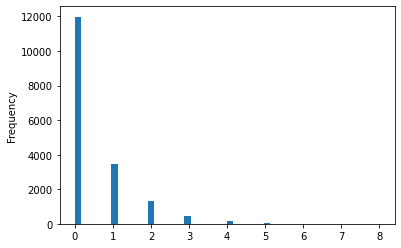

In [232]:
# Create a distribution of frequency to understand the customer frequence level
summary['frequency'].plot(kind='hist', bins=50)



In [233]:

one_time_buyers = round(sum(summary['frequency'] == 0)/float(len(summary))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

Percentage of customers purchase the item only once: 68.82 %


In [234]:
import datetime as dt
TRAIN = super_store_data[super_store_data["Order Date"] < super_store_data["Order Date"].max() - dt.timedelta(days = 30)]
TRAIN.shape

(49137, 23)

In [235]:
TEST =  super_store_data[super_store_data["Order Date"] >= super_store_data["Order Date"].max() - dt.timedelta(days = 30)]
TEST.shape

(2153, 23)

In [236]:
GD_data_LT = lifetimes.utils.summary_data_from_transaction_data(TRAIN, 'Customer ID', 'Order Date', 'Sales' )
GD_data_LT.head()

# frequency: total number of repeat purchases
# recency: the difference between the customer's last purchase and his first purchase
# T: the age of the client in the company
# monetary_value: average earnings per purchase

,frequency,recency,T,monetary_value
Customer ID,,,,
AA-10315102,1.0,918.0,1245.0,139.9275
AA-10315120,0.0,0.0,928.0,0.0000
AA-10315139,3.0,319.0,437.0,923.3060
AA-103151402,1.0,483.0,636.0,374.4800
AA-103151404,1.0,553.0,1340.0,26.9600


count    16891.000000
mean         0.457522
std          0.825521
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          8.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers that purchased the item only once: 69.55 %


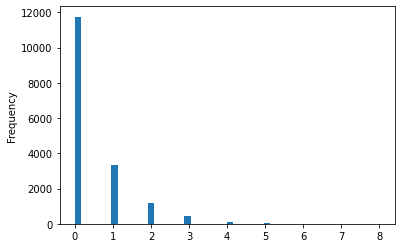

In [237]:
# Create a distribution of frequency to understand the customer frequency level
GD_data_LT['frequency'].plot(kind='hist', bins=50)
print(GD_data_LT['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(GD_data_LT['frequency'] == 0)/float(len(GD_data_LT))*(100),2)
print("Percentage of customers that purchased the item only once:", one_time_buyers ,"%")

In [238]:
# Fitting the BG/NBD model
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(GD_data_LT['frequency'], GD_data_LT['recency'], GD_data_LT['T'])
# Model summary
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.697719,1.006643e-01,1.500417e+00,1.895021e+00
alpha,2513.176428,1.527880e+02,2.213712e+03,2.812641e+03
a,0.000203,4.121077e-01,-8.075282e-01,8.079340e-01
b,3336.103385,6.751025e+06,-1.322867e+07,1.323534e+07


In [239]:
# Compute the customer alive probability
GD_data_LT['probability_alive'] = bgf.conditional_probability_alive(GD_data_LT['frequency'], GD_data_LT['recency'], GD_data_LT['T'])
GD_data_LT.head(10)

,frequency,recency,T,monetary_value,probability_alive
Customer ID,,,,,
AA-10315102,1.0,918.0,1245.0,139.9275,1.0
AA-10315120,0.0,0.0,928.0,0.0000,1.0
AA-10315139,3.0,319.0,437.0,923.3060,1.0
AA-103151402,1.0,483.0,636.0,374.4800,1.0
AA-103151404,1.0,553.0,1340.0,26.9600,1.0
AA-103151406,0.0,0.0,1172.0,0.0000,1.0
AA-1031548,0.0,0.0,480.0,0.0000,1.0
AA-1031558,0.0,0.0,334.0,0.0000,1.0
AA-103157,0.0,0.0,97.0,0.0000,1.0


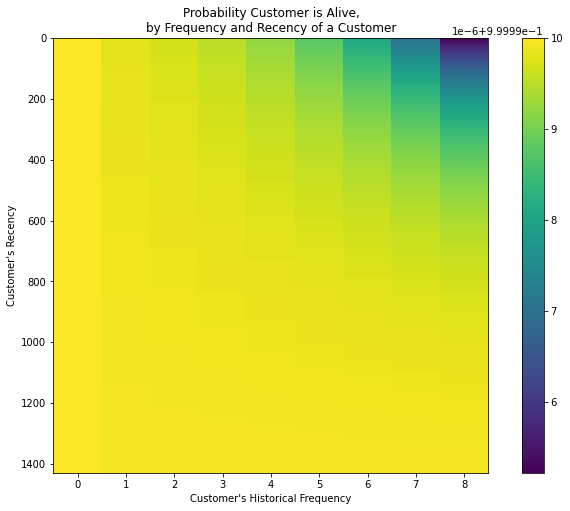

In [240]:
# Visual representation of relationship between recency and frequency
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)
plt.show()

In [241]:
#Predict future transaction for the next 30 days based on historical dataa
t = 30
GD_data_LT['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, GD_data_LT['frequency'], GD_data_LT['recency'], GD_data_LT['T']),2)
GD_data_LT.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,Customer ID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
0,CS-121757,8.0,1012.0,1311.0,680.714250,1.0,0.08
1,DB-1361548,7.0,656.0,1202.0,410.364000,1.0,0.07
2,BD-113201404,6.0,591.0,593.0,184.984667,1.0,0.07
3,AR-1082545,6.0,861.0,909.0,555.065000,1.0,0.07
4,JC-1534045,4.0,532.0,535.0,579.093750,1.0,0.06
5,SC-206951402,6.0,1022.0,1080.0,303.901333,1.0,0.06
6,DM-1352582,4.0,579.0,583.0,467.076920,1.0,0.06
7,KL-166451402,4.0,365.0,555.0,634.341750,1.0,0.06
8,PS-1876082,5.0,1014.0,1018.0,614.024800,1.0,0.06
9,MD-1735082,5.0,1074.0,1136.0,332.004800,1.0,0.06


In [242]:
# Checking the relationship between frequency and monetary_value
GD_return_customers_summary = GD_data_LT[GD_data_LT['frequency']>0]
print(GD_return_customers_summary.shape)
GD_return_customers_summary.head()

(5143, 6)


,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
Customer ID,,,,,,
AA-10315102,1.0,918.0,1245.0,139.9275,1.0,0.02
AA-10315139,3.0,319.0,437.0,923.3060,1.0,0.05
AA-103151402,1.0,483.0,636.0,374.4800,1.0,0.03
AA-103151404,1.0,553.0,1340.0,26.9600,1.0,0.02
AA-1031582,1.0,439.0,1102.0,61.3000,1.0,0.02


In [243]:
# Checking the relationship between frequency and monetary_value
GD_return_customers_summary[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.001725
monetary_value,0.001725,1.000000


In [244]:
# Modeling the monetary value using Gamma-Gamma Model
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(GD_return_customers_summary['frequency'], GD_return_customers_summary['monetary_value'])
# Summary of the fitted parameters
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.373907,0.066093,3.244365,3.503450
q,0.335324,0.005328,0.324881,0.345768
v,3.170847,0.068221,3.037135,3.304560


In [245]:
# Calculating the conditional expected average profit for each customer per transaction
GD_data_LT_vF = GD_data_LT[GD_data_LT['monetary_value'] >0]
GD_data_LT_vF['exp_avg_sales'] = ggf.conditional_expected_average_profit(GD_data_LT_vF['frequency'],
                                       GD_data_LT_vF['monetary_value'])
GD_data_LT_vF.head()

,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales
Customer ID,,,,,,,
AA-10315102,1.0,918.0,1245.0,139.9275,1.0,0.02,178.205709
AA-10315139,3.0,319.0,437.0,923.3060,1.0,0.05,989.330536
AA-103151402,1.0,483.0,636.0,374.4800,1.0,0.03,470.302684
AA-103151404,1.0,553.0,1340.0,26.9600,1.0,0.02,37.523068
AA-1031582,1.0,439.0,1102.0,61.3000,1.0,0.02,80.287951


In [246]:
# Checking the expected average value and the actual average value in the data to make sure the values are good
print(f"Expected Average Sales: {GD_data_LT_vF['exp_avg_sales'].mean()}")
print(f"Actual Average Sales: {GD_data_LT_vF['monetary_value'].mean()}")

Expected Average Sales: 613.0187971889736
Actual Average Sales: 511.3382036724357


In [247]:
# Predicting Customer Lifetime Value for the next 30 days
GD_data_LT_vF['predicted_clv'] =      ggf.customer_lifetime_value(bgf,
                                                               GD_data_LT_vF['frequency'],
                                                               GD_data_LT_vF['recency'],
                                                               GD_data_LT_vF['T'],
                                                               GD_data_LT_vF['monetary_value'],
                                                               time=1,     # lifetime in months
                                                               freq='D',   # frequency in which the data is present(T)      
                                                               discount_rate=0.01) # discount rate
GD_data_LT_vF.head()

,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv
Customer ID,,,,,,,,
AA-10315102,1.0,918.0,1245.0,139.9275,1.0,0.02,178.205709,3.799627
AA-10315139,3.0,319.0,437.0,923.3060,1.0,0.05,989.330536,46.792935
AA-103151402,1.0,483.0,636.0,374.4800,1.0,0.03,470.302684,11.966771
AA-103151404,1.0,553.0,1340.0,26.9600,1.0,0.02,37.523068,0.780326
AA-1031582,1.0,439.0,1102.0,61.3000,1.0,0.02,80.287951,1.779579


In [248]:
GD_data_LT_vF['manual_predicted_clv'] = GD_data_LT_vF['pred_num_txn'] * GD_data_LT_vF['exp_avg_sales']
GD_data_LT_vF.head()

,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv
Customer ID,,,,,,,,,
AA-10315102,1.0,918.0,1245.0,139.9275,1.0,0.02,178.205709,3.799627,3.564114
AA-10315139,3.0,319.0,437.0,923.3060,1.0,0.05,989.330536,46.792935,49.466527
AA-103151402,1.0,483.0,636.0,374.4800,1.0,0.03,470.302684,11.966771,14.109081
AA-103151404,1.0,553.0,1340.0,26.9600,1.0,0.02,37.523068,0.780326,0.750461
AA-1031582,1.0,439.0,1102.0,61.3000,1.0,0.02,80.287951,1.779579,1.605759


#### Test

In [249]:
TEST.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Postal Code,City,State,Country,Region,Market,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
19,49463,TZ-2015-RH9555129-42343,2015-12-05,2015-12-07,Second Class,RH-9555129,Consumer,NaN,Uvinza,Kigoma,Tanzania,Eastern Africa,Africa,OFF-AP-4967,Office Supplies,Appliances,"KitchenAid Stove, White",3409.740,6,0.0,818.280,763.380,High
49,6550,MX-2015-JH15820141-42356,2015-12-18,2015-12-20,Second Class,JH-15820141,Consumer,NaN,Paysandú,Paysandú,Uruguay,South America,LATAM,FUR-CH-4531,Furniture,Chairs,"Harbour Creations Executive Leather Armchair, ...",3473.140,11,0.0,868.120,634.529,High
61,34496,CA-2015-AH10030140-42357,2015-12-19,2015-12-23,Standard Class,AH-100301406,Corporate,19134.0,Philadelphia,Pennsylvania,United States,Eastern US,USCA,OFF-AR-3276,Office Supplies,Art,Avery Fluorescent Highlighter Four-Color Set,18.704,7,0.2,2.338,1.130,Medium
66,16653,IT-2015-DK13090120-42345,2015-12-07,2015-12-08,First Class,DK-13090120,Consumer,NaN,Seville,Andalusía,Spain,Southern Europe,Europe,FUR-BO-5760,Furniture,Bookcases,"Safco Classic Bookcase, Metal",2188.050,5,0.0,1050.150,593.910,High
67,28932,IN-2015-CS1184558-42354,2015-12-16,2015-12-19,First Class,CS-1184558,Corporate,NaN,Raipur,Uttarakhand,India,Southern Asia,Asia Pacific,FUR-TA-3779,Furniture,Tables,"Chromcraft Wood Table, Rectangular",1920.360,4,0.0,652.920,592.770,Critical


In [250]:
ACTUAL = TEST.groupby("Customer ID")["Sales"].sum().reset_index()

In [251]:
ACTUAL.rename(columns ={"Sales":"actual_amount_spent_in_next_30_days"}, inplace = True)

In [252]:
Pred_vs_Actual = GD_data_LT_vF.merge(ACTUAL, on = "Customer ID", how = "left")
Pred_vs_Actual.fillna(0, inplace = True)

In [253]:
Pred_vs_Actual.head()

,Customer ID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,actual_amount_spent_in_next_30_days
0,AA-10315102,1.0,918.0,1245.0,139.9275,1.0,0.02,178.205709,3.799627,3.564114,0.0
1,AA-10315139,3.0,319.0,437.0,923.3060,1.0,0.05,989.330536,46.792935,49.466527,0.0
2,AA-103151402,1.0,483.0,636.0,374.4800,1.0,0.03,470.302684,11.966771,14.109081,0.0
3,AA-103151404,1.0,553.0,1340.0,26.9600,1.0,0.02,37.523068,0.780326,0.750461,0.0
4,AA-1031582,1.0,439.0,1102.0,61.3000,1.0,0.02,80.287951,1.779579,1.605759,0.0


In [254]:
Pred_vs_Actual["difference"] = Pred_vs_Actual["manual_predicted_clv"] - Pred_vs_Actual["actual_amount_spent_in_next_30_days"]

In [255]:
Pred_vs_Actual.head()

,Customer ID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,actual_amount_spent_in_next_30_days,difference
0,AA-10315102,1.0,918.0,1245.0,139.9275,1.0,0.02,178.205709,3.799627,3.564114,0.0,3.564114
1,AA-10315139,3.0,319.0,437.0,923.3060,1.0,0.05,989.330536,46.792935,49.466527,0.0,49.466527
2,AA-103151402,1.0,483.0,636.0,374.4800,1.0,0.03,470.302684,11.966771,14.109081,0.0,14.109081
3,AA-103151404,1.0,553.0,1340.0,26.9600,1.0,0.02,37.523068,0.780326,0.750461,0.0,0.750461
4,AA-1031582,1.0,439.0,1102.0,61.3000,1.0,0.02,80.287951,1.779579,1.605759,0.0,1.605759


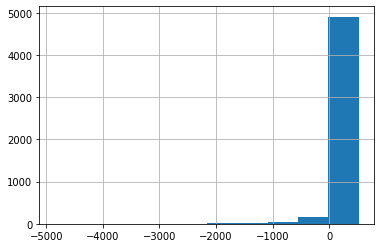

In [256]:
Pred_vs_Actual["difference"].hist()

In [257]:
Pred_vs_Actual["difference"].describe()

count    5143.000000
mean       -8.261016
std       207.666741
min     -4853.738348
25%         2.283539
50%         7.661299
75%        20.487154
max       525.120785
Name: difference, dtype: float64

In [258]:
Pred_vs_Actual.sort_values('actual_amount_spent_in_next_30_days', ascending = False)

,Customer ID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,actual_amount_spent_in_next_30_days,difference
4736,TA-213857,1.0,165.0,1101.0,421.6800,1.0,0.02,529.082604,11.730341,10.581652,4864.3200,-4853.738348
908,CD-1192045,2.0,646.0,729.0,57.1455,1.0,0.03,65.148172,2.206985,1.954445,4046.6790,-4044.724555
2777,KH-165101404,2.0,405.0,1152.0,377.1070,1.0,0.03,420.070338,12.588119,12.602110,3955.5070,-3942.904890
345,AS-1004545,2.0,645.0,1252.0,171.3600,1.0,0.03,191.842345,5.596195,5.755270,3788.3310,-3782.575730
3150,MC-1742559,1.0,82.0,529.0,101.7174,1.0,0.03,130.621246,3.440535,3.918637,3696.0315,-3692.112863
...,...,...,...,...,...,...,...,...,...,...,...,...
1771,ES-14080139,1.0,205.0,950.0,14.9700,1.0,0.02,22.591474,0.522717,0.451829,0.0000,0.451829
1770,ES-1402059,1.0,652.0,818.0,32.8332,1.0,0.02,44.837183,1.078542,0.896744,0.0000,0.896744
1767,ES-1402028,1.0,61.0,233.0,86.9600,1.0,0.03,112.243306,3.275130,3.367299,0.0000,3.367299
1766,ES-1402027,4.0,638.0,912.0,285.4875,1.0,0.05,301.110245,14.877962,15.055512,0.0000,15.055512


In [259]:
# MAE of the Lifetimes based prediction
mean_absolute_error(Pred_vs_Actual["actual_amount_spent_in_next_30_days"],Pred_vs_Actual["manual_predicted_clv"])

40.773063011908135

In [260]:
Pred_vs_Actual.to_csv("lifetimes_based_global_datastore.csv")